In [1]:
import os
import re
import sys
import json
import warnings
import matplotlib
import subprocess
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms

from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

sys.path.append('../modules')
import plot_hurst_tfs as plt_hurst_tfs

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "olive", "gray", "cyan"]

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2023-06-08"

In [3]:
# Stock indexes
list_stock_indexes = {
    #"^GSPC" : "Standard and Poor's 500", # S&P 500 (United States)
    "^DJI" : "Dow Jones Industrial Average", # Dow Jones Industrial Average (United States)
    #"^W5000" : "Wilshire 5000", # Wilshire 5000 (United States)
    #"^GSPTSE" : "Toronto Stock Exchange Composite index", # S&P/TSX Composite index (Canada)
    #"^GDAXI" : "German Stock index", # DAX Performance index (Germany)
    #"^FTSE" : "Financial Times Stock Exchange 100", # FTSE 100 (United Kingdom)
    #"^IBEX" : "Iberia Index 35", # Iberia Index (Spain)
    "^FCHI" : "Continuous Assisted Quotation 40", # CAC 40 (France)
    "^IXIC" : "National Association of Securities Dealers Automated Quotation Composite", # NASDAQ Composite (United States)
    #"IMOEX.ME" : "Moscow Stock Exchange", # MOEX Russia Index (Russia)
    #"^N225" : "Nikkei Heikin Kabuka Stock Exchange 225", # Nikkei 225 (Japan)
    #"^STI" : "Straits Times Index 30", # STI Index (Singapore)
    #"^BVSP" : "Sao Paulo Stock Exchange", # IBOVESPA (Brazil)
    "^MERV" : "Buenos Aires Stock Exchange" # MERVAL (Argentine)
}

In [4]:
# Currencies
list_currencies = {
    #"KWDUSD=X" : "Currency exchange rate from Kuwaiti Dinar to U.S. dollar", # KWD/USD
    #"BHDUSD=X" : "Currency exchange rate from Bahraini Dinar to U.S. dollar", # BHD/USD
    #"OMRUSD=X" : "Currency exchange rate from Omani Rial to U.S. dollar", # OMR/USD    
    #"JODUSD=X" : "Currency exchange rate from Jordanian Dinar to U.S. dollar", # JOD/USD
    #"KYDUSD=X" : "Currency exchange rate from Cayman Islands dollar to U.S. dollar", # KYD/USD
    #"GBPUSD=X" : "Currency exchange rate from U.K. pound sterling to U.S. dollar", # GBP/USD
    #"CHFUSD=X" : "Currency exchange rate from swiss franc to U.S. dollar", # CHF/USD
    #"EURUSD=X" : "Currency exchange rate from euro to U.S. dollar", # EUR/USD
    #"SGD=X" : "Currency exchange rate from U.S. dollar to Singapore dollar", # USD/SGD
    #"CAD=X" : "Currency exchange rate from U.S. dollar to Canadian dollar", # USD/CAD
    #"AUD=X" : "Currency exchange rate from U.S. dollar to Australian dollar", # USD/AUD
    #"NZD=X" : "Currency exchange rate from U.S. dollar to New Zealand dollar", # USD/NZD
    #"MYR=X" : "Currency exchange rate from U.S. dollar to malaysian ringgit", # USD/MYR    
    #"BRL=X" : "Currency exchange rate from U.S. dollar to Brazilian real", # USD/BRL    
    #"CNY=X" : "Currency exchange rate from U.S. dollar to chinese renminbi", # USD/CNY
    #"HKD=X" : "Currency exchange rate from U.S. dollar to Hong Kong dollar", # USD/HKD
    #"SEK=X" : "Currency exchange rate from U.S. dollar to swedish krona", # USD/SEK
    #"ZAR=X" : "Currency exchange rate from U.S. dollar to South African rand", # USD/ZAR
    "MXN=X" : "Currency exchange rate from U.S. dollar to mexican peso", # USD/MXN
    #"THB=X" : "Currency exchange rate from U.S. dollar to thai baht", # USD/THB
    #"PHP=X" : "Currency exchange rate from U.S. dollar to philippines peso", # USD/PHP
    #"RUB=X" : "Currency exchange rate from U.S. dollar to russian ruble", # USD/RUB
    #"INR=X" : "Currency exchange rate from U.S. dollar to indian rupee", # USD/INR
    #"JPY=X" : "Currency exchange rate from U.S. dollar to japanese yen", # USD/JPY    
    #"HUF=X" : "Currency exchange rate from U.S. dollar to hungarian forints", # USD/HUF
    #"COP=X" : "Currency exchange rate from U.S. dollar to colombian peso", # USD/COP
    #"IDR=X" : "Currency exchange rate from U.S. dollar to indonesian rupiah", # USD/IDR
    "EURCOP=X" : "Currency exchange rate from euro to colombian peso" # EUR/COP
}

## Load time series

In [5]:
df_stock_indexes = pd.read_csv("{}/df_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies = pd.read_csv("{}/df_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_hurst = pd.read_csv("{}/df_hurst_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_hurst = pd.read_csv("{}/df_hurst_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_tfs = pd.read_csv("{}/df_tfs_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_tfs = pd.read_csv("{}/df_tfs_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

df_stock_indexes_tts = pd.read_csv("{}/df_tts_stock_index_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)
df_currencies_tts = pd.read_csv("{}/df_tts_currency_{}.csv".format(input_path_processed, re.sub("-", "", input_generation_date)), low_memory = False)

In [6]:
df_stock_indexes["symbol"].value_counts()

^GSPC       23659
^N225       14170
^IXIC       13160
^GSPTSE     11016
^FTSE        9938
^GDAXI       8956
^STI         8830
^W5000       8667
^FCHI        8428
^DJI         7906
^IBEX        7556
^BVSP        7433
^MERV        6506
PSI20.LS     2573
IMOEX.ME     2520
Name: symbol, dtype: int64

In [7]:
df_currencies["symbol"].value_counts()

JPY=X       6856
SEK=X       5518
IDR=X       5396
HKD=X       5266
CAD=X       5115
CHFUSD=X    5106
ZAR=X       5072
MXN=X       5067
GBPUSD=X    5053
HUF=X       5050
SGD=X       5044
EURUSD=X    5040
NZD=X       5037
THB=X       4967
INR=X       4965
MYR=X       4938
COP=X       4865
CNY=X       4839
RUB=X       4786
EURCOP=X    4662
PHP=X       4621
BRL=X       4578
AUD=X       4415
BHDUSD=X    4404
KWDUSD=X    4151
OMRUSD=X    3914
KYDUSD=X    3508
JODUSD=X    2566
Name: symbol, dtype: int64

## Cross Temporal Fluctuation Scaling exponent and Hurst exponent

In [8]:
q_values = [-2, -1, 0, 1, 2]

In [9]:
if os.path.exists("{}/{}".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)))
if os.path.exists("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date))) == False:
    os.mkdir("{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)))

In [10]:
df_resume = plt_hurst_tfs.prepare_data(
    df_fts = df_currencies,#df_stock_indexes,
    df_hurst = df_currencies_hurst,#df_stock_indexes_hurst,
    df_tfs = df_currencies_tfs,#df_stock_indexes_tfs,
    df_tts = df_currencies_tts,#df_stock_indexes_tts,
    interval = "days",
    threshold_n_data_hurst = 4096,
    threshold_tfs = 0.1,
    threshold_tts = 0.01
)
df_resume.drop_duplicates(["symbol", "min_date", "max_date"])

,date,symbol,step,cummean,cumvariance,time_series,min_date,max_date,duration,q_order,dfa_degree,hurst,p_norm_tfs,coefficient_tfs,error_coefficient_tfs,exponent_tfs,error_exponent_tfs,average_error_tfs,rsquared_tfs,p_norm_tts,coefficient_tts,error_coefficient_tts,exponent_tts,error_exponent_tts,average_error_tts,rsquared_tts
2500,2019-10-23,KWDUSD=X,4110,0.001968,1.148495e-05,absolute log-return,2003-12-03,2023-06-07,7126.0,-2,1,3.099420,2,3.781215e-01,7.579542e-02,1.719273,0.033882,0.001913,0.445291,2,0.956536,0.000719,1.570196e-01,0.000947,0.160873,9.224374e-01
6820,2019-05-06,BHDUSD=X,4110,0.006228,8.200065e-04,absolute log-return,2002-04-02,2023-06-07,7736.0,-2,1,NaN,2,1.051519e-02,5.920844e-03,0.724025,0.111621,0.014038,0.051060,2,0.976504,0.000559,1.169420e-01,0.000491,0.126741,9.633724e-01
10765,2019-09-18,OMRUSD=X,4110,0.001191,1.495597e-05,absolute log-return,2004-02-20,2023-06-07,7047.0,-2,1,NaN,2,2.345938e-01,3.684002e-02,1.448852,0.024184,0.001346,0.637513,2,0.968799,0.000668,1.608565e-01,0.000834,0.142328,9.486690e-01
14045,2019-09-10,JODUSD=X,4110,0.001389,3.890479e-06,absolute log-return,2003-12-05,2023-06-01,7118.0,-2,1,NaN,2,2.019871e-05,2.243775e-06,0.197558,0.018155,0.001145,0.059883,2,0.997265,0.000547,3.230848e-01,0.001098,0.109315,9.822349e-01
18015,2019-09-26,GBPUSD=X,4110,0.004349,1.694025e-05,absolute log-return,2003-12-02,2023-06-07,7127.0,-2,1,0.789568,2,1.218913e-01,2.039839e-02,1.653184,0.031112,0.001386,0.431121,2,1.005357,0.000476,1.566040e-01,0.000460,0.098817,9.742594e-01
23070,2019-07-12,CHFUSD=X,4110,0.004761,2.988038e-05,absolute log-return,2003-09-18,2023-06-07,7202.0,-2,1,0.796692,2,5.696855e-05,1.478759e-05,0.142097,0.049528,0.001994,0.007167,2,0.997055,0.000449,1.607214e-01,0.000474,0.095406,9.739125e-01
28115,2019-10-14,EURUSD=X,4110,0.004723,3.700016e-05,absolute log-return,2003-12-02,2023-06-07,7127.0,-2,1,0.814696,2,4.516251e+04,1.780656e+04,3.939979,0.075127,0.002680,0.498246,2,0.992045,0.000489,1.498186e-01,0.000496,0.103209,9.675241e-01
33135,2019-09-26,SGD=X,4110,0.002463,5.433618e-06,absolute log-return,2003-12-02,2023-06-07,7127.0,-2,1,0.871524,2,2.981832e+02,2.633998e+01,2.964785,0.014686,0.000446,0.940420,2,1.004028,0.000475,1.397776e-01,0.000417,0.098432,9.732596e-01
38195,2019-07-10,CAD=X,4110,0.004246,1.578431e-05,absolute log-return,2003-09-18,2023-06-07,7202.0,-2,1,0.784965,2,5.750434e+01,6.849667e+00,2.784940,0.022131,0.001050,0.807188,2,0.994706,0.000447,1.512416e-01,0.000450,0.095718,9.738680e-01
43040,2022-03-04,AUD=X,4110,0.006414,1.547105e-03,absolute log-return,2006-05-17,2023-06-07,6230.0,-2,1,0.816828,2,1.778345e+02,5.918828e+00,2.245673,0.007973,0.029564,0.934869,2,0.994175,0.000853,2.217889e-01,0.001276,0.121529,9.217249e-01


Generated plot for ^IBEX and time series absolute log-return
Generated plot for ^IBEX and time series log-return volatility


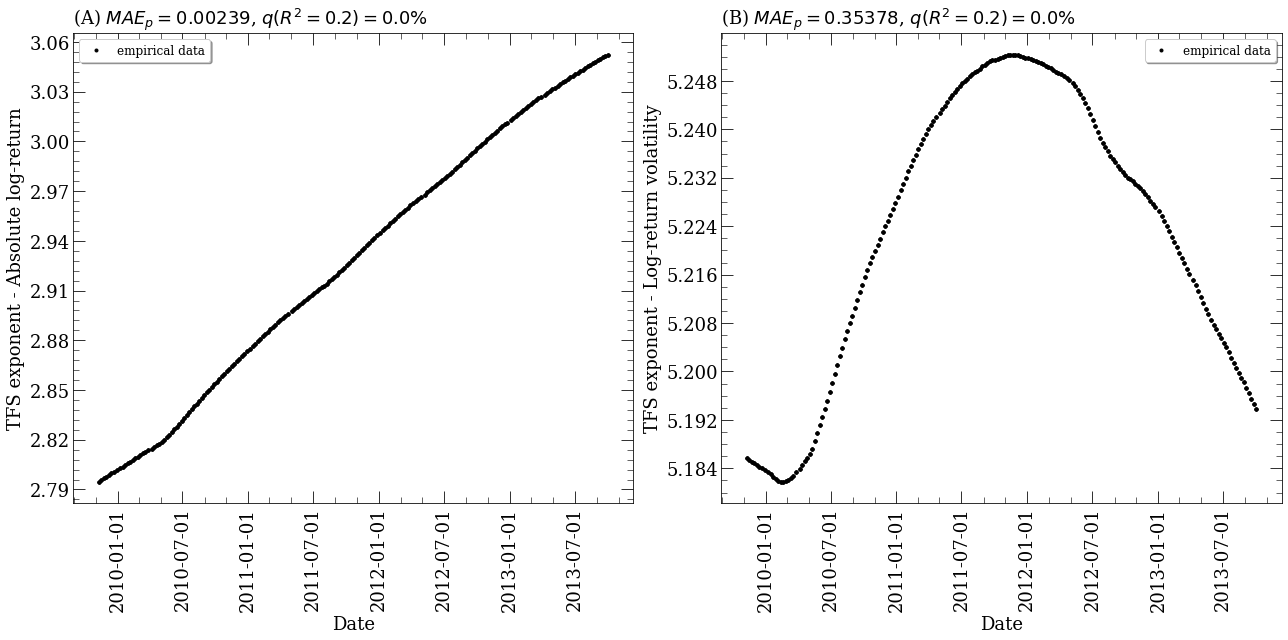

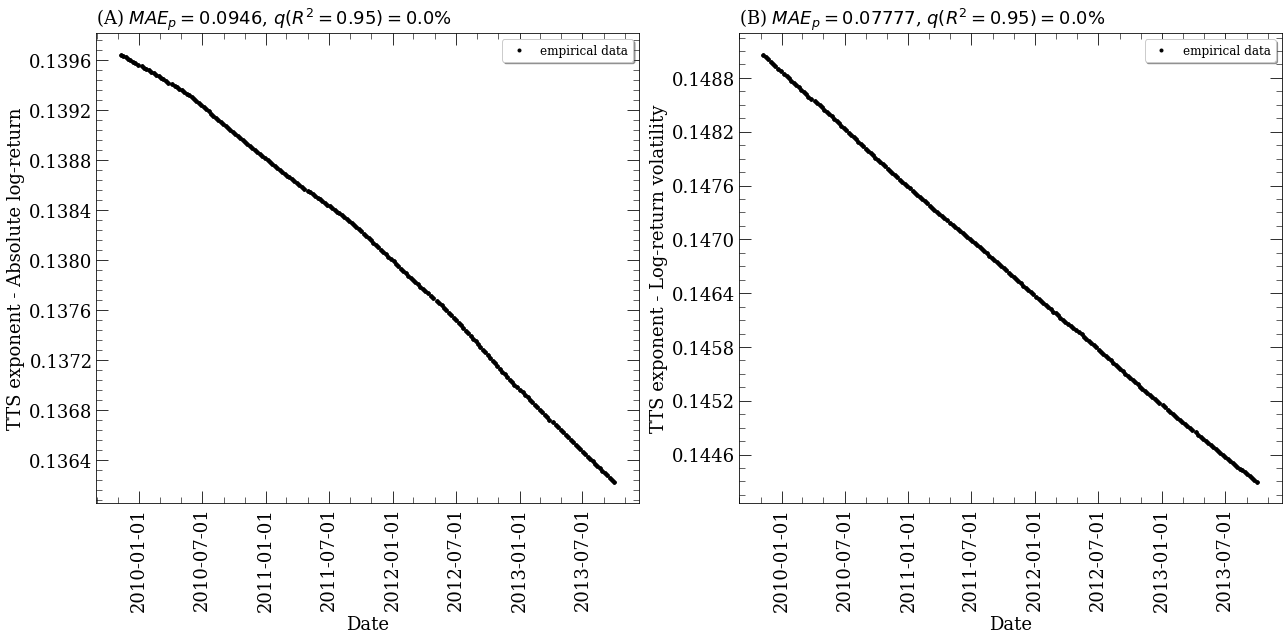

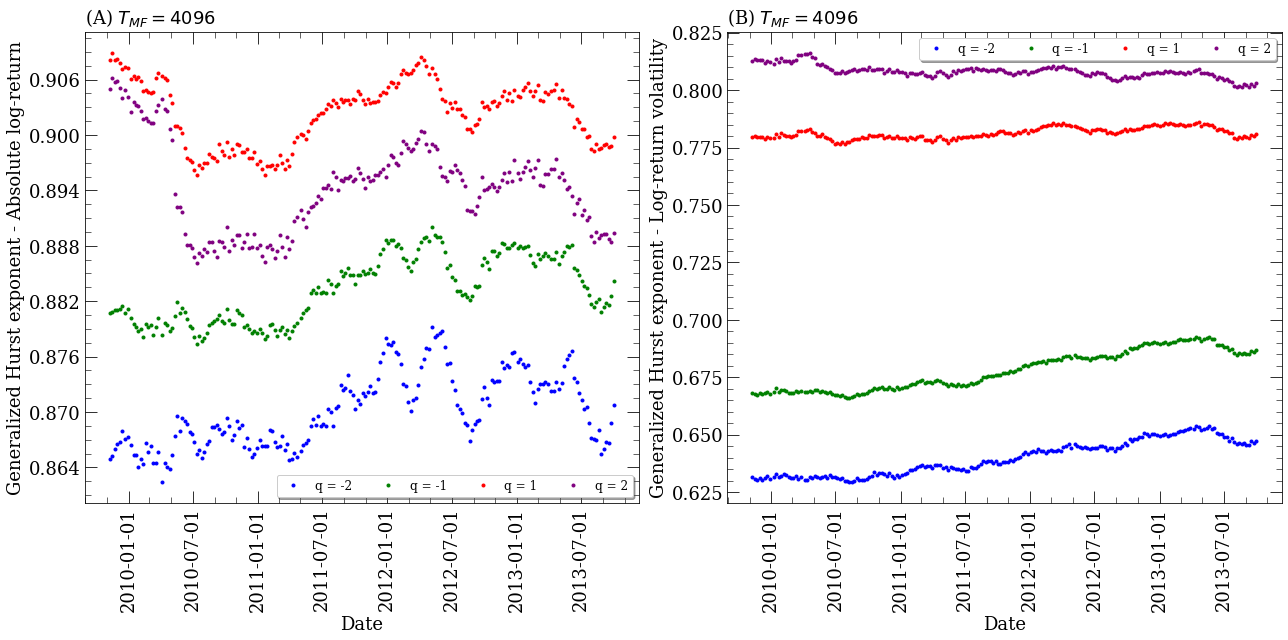

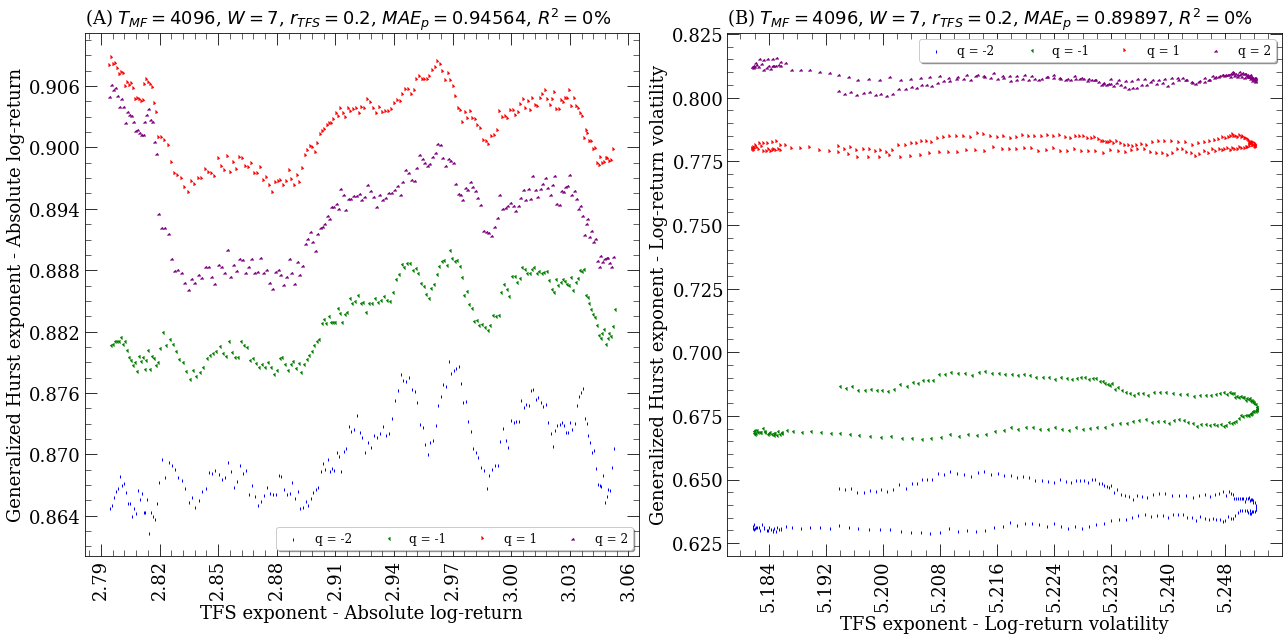

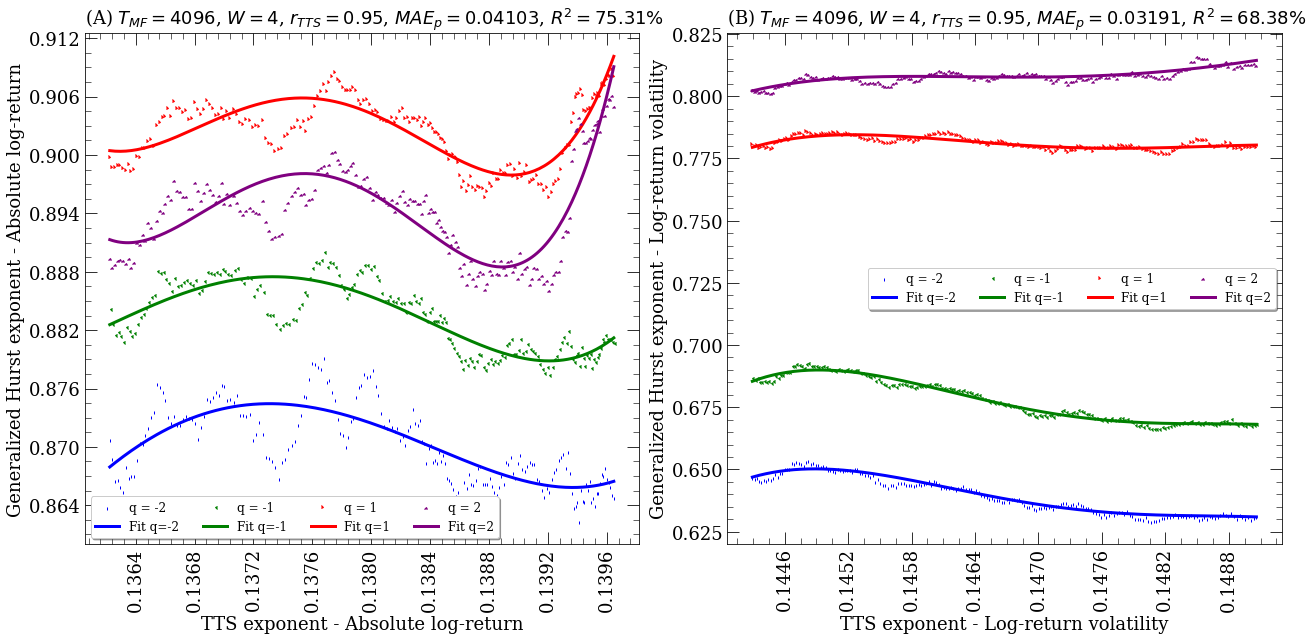

0


In [23]:
plt_hurst_tfs.plot_hurst_tfs_tts_evolution(
    df_fts = df_stock_indexes,
    df_hurst = df_stock_indexes_hurst,
    df_tfs = df_stock_indexes_tfs,
    df_tts = df_stock_indexes_tts,
    interval = "days",
    symbols = ["^IBEX"],
    q_values = q_values,
    degree_tfs = 7,
    degree_tts = 4,
    width = 18,
    height = 9,
    threshold_n_data_hurst = 4096,
    threshold_tfs = 0.20,
    threshold_tts = 0.95,
    markersize = 3,
    fontsize_labels = 18,
    fontsize_legend = 12,
    usetex = False,
    n_cols = 4,
    n_x_breaks = 10,
    n_y_breaks = 10,
    fancy_legend = True,
    dpi = 150,
    save_figures = True,
    output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
    information_name = re.sub("(\^)|(=X)", "", "^IBEX"),
    input_generation_date = input_generation_date
)
print(0)

Generated plot for ^DJI and time series absolute log-return
Generated plot for ^DJI and time series log-return volatility


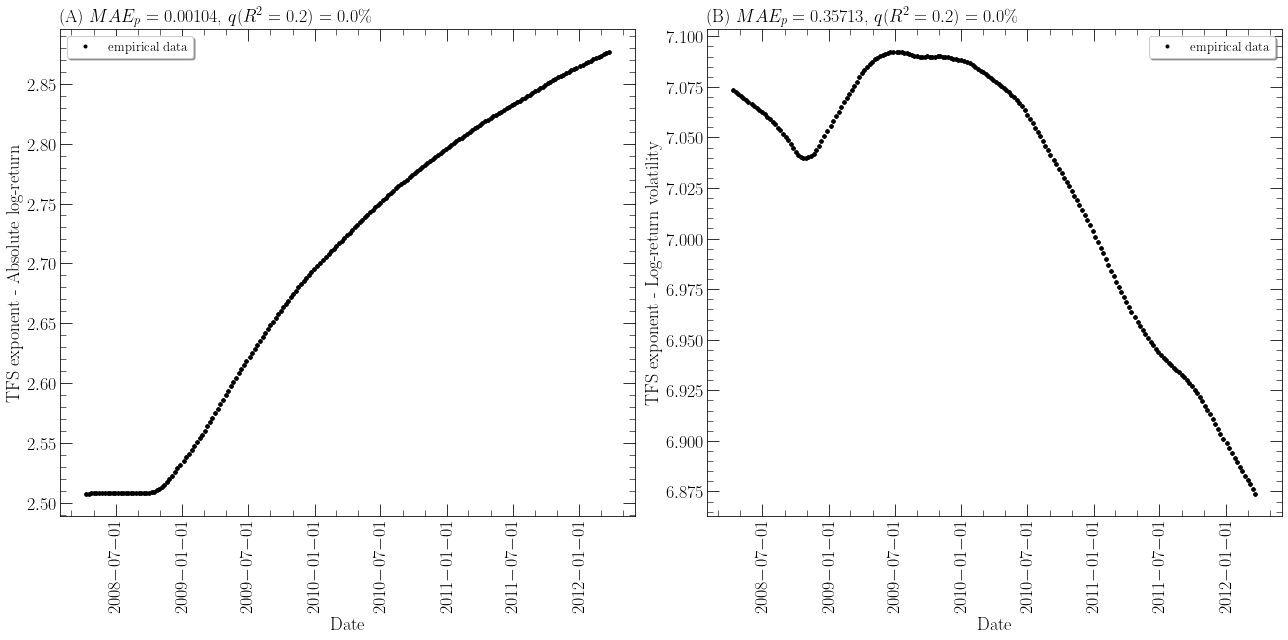

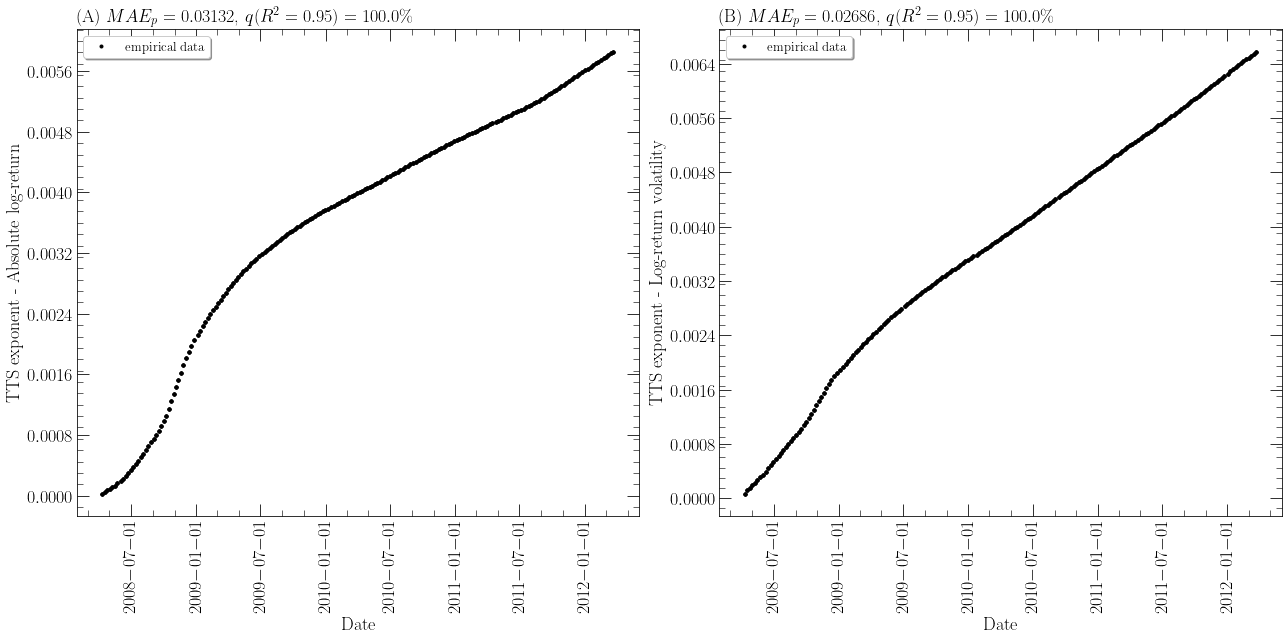

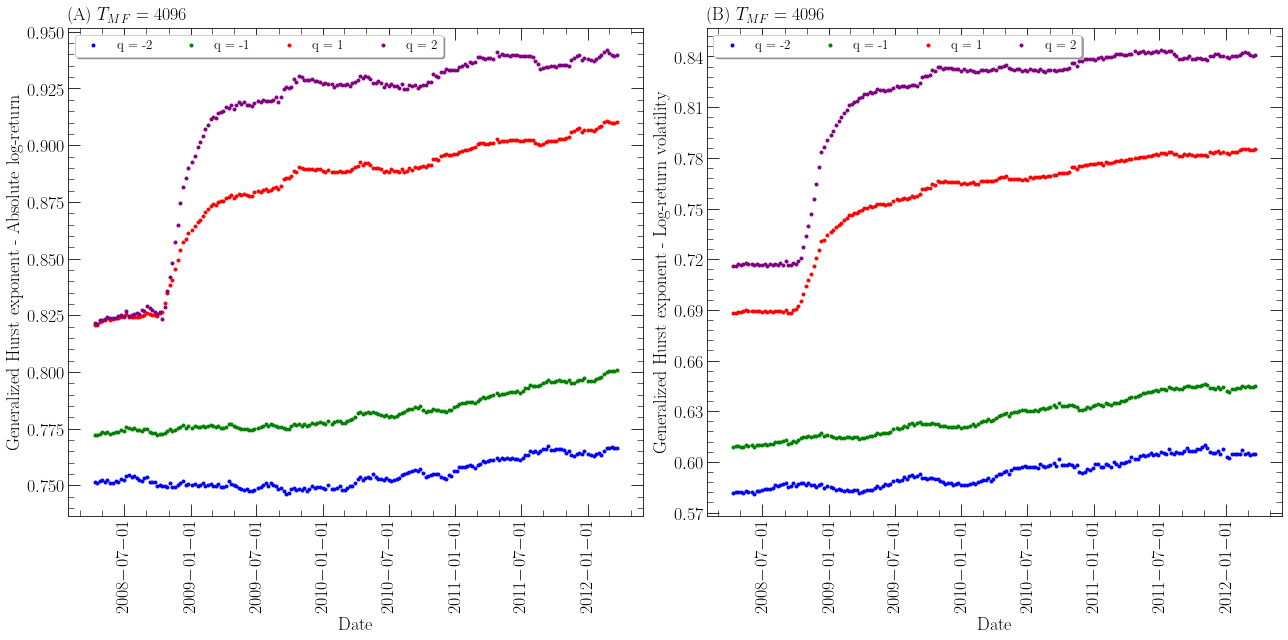

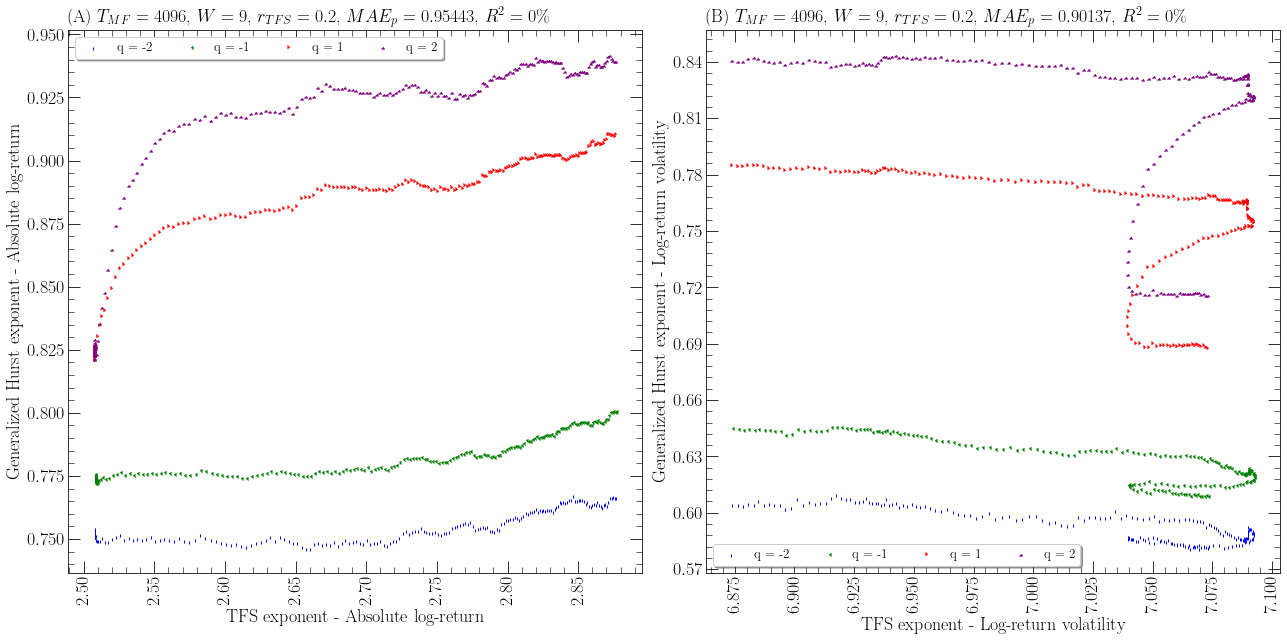

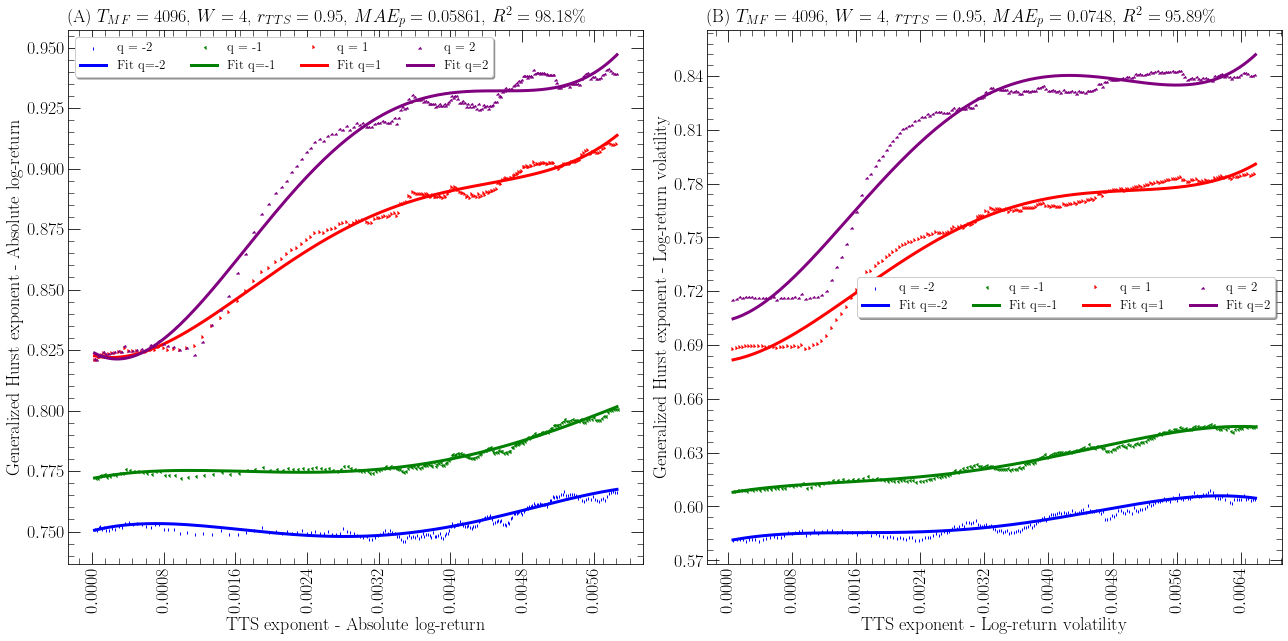

Generated plot for ^FCHI and time series absolute log-return
Generated plot for ^FCHI and time series log-return volatility


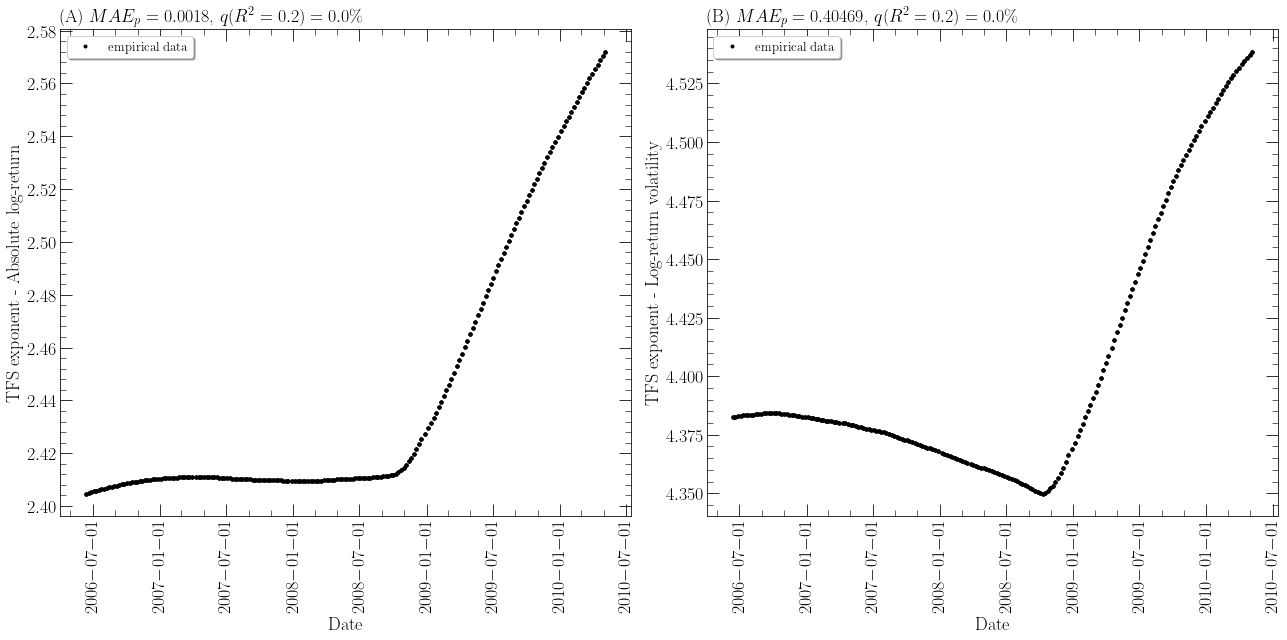

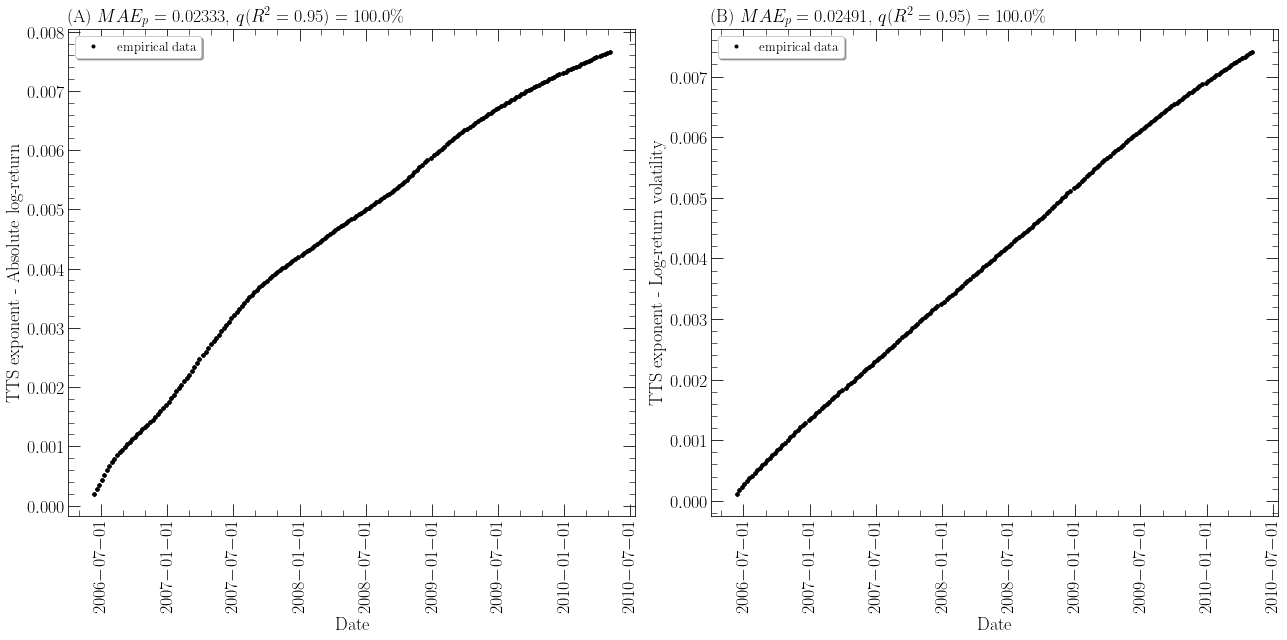

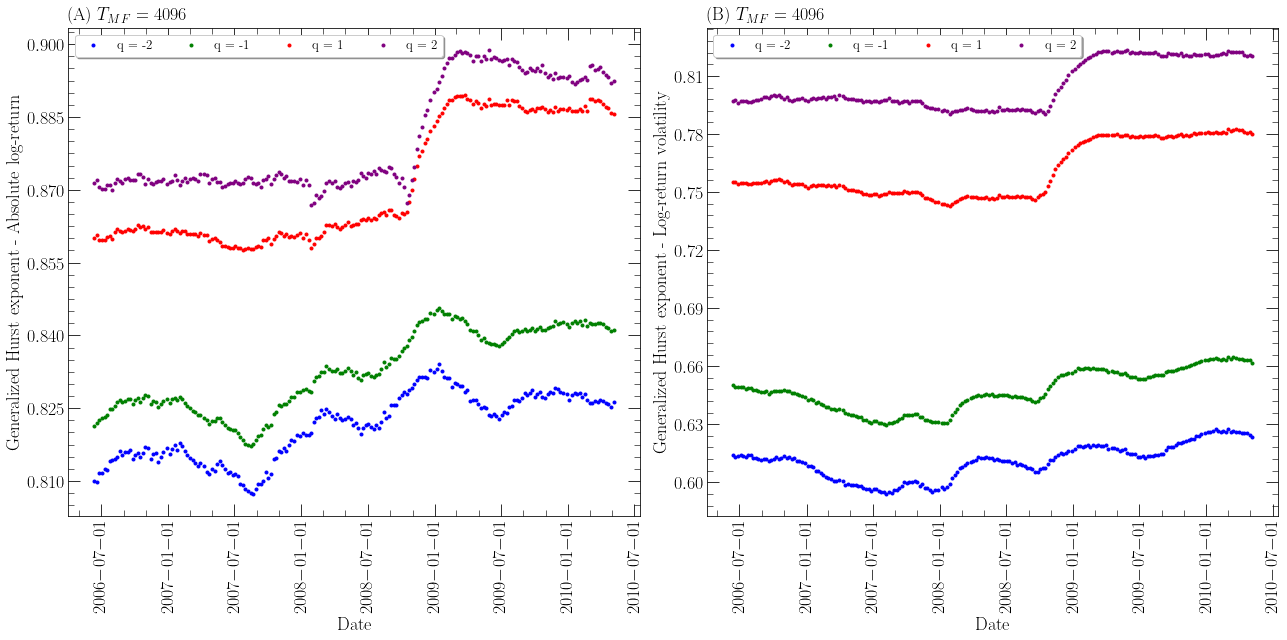

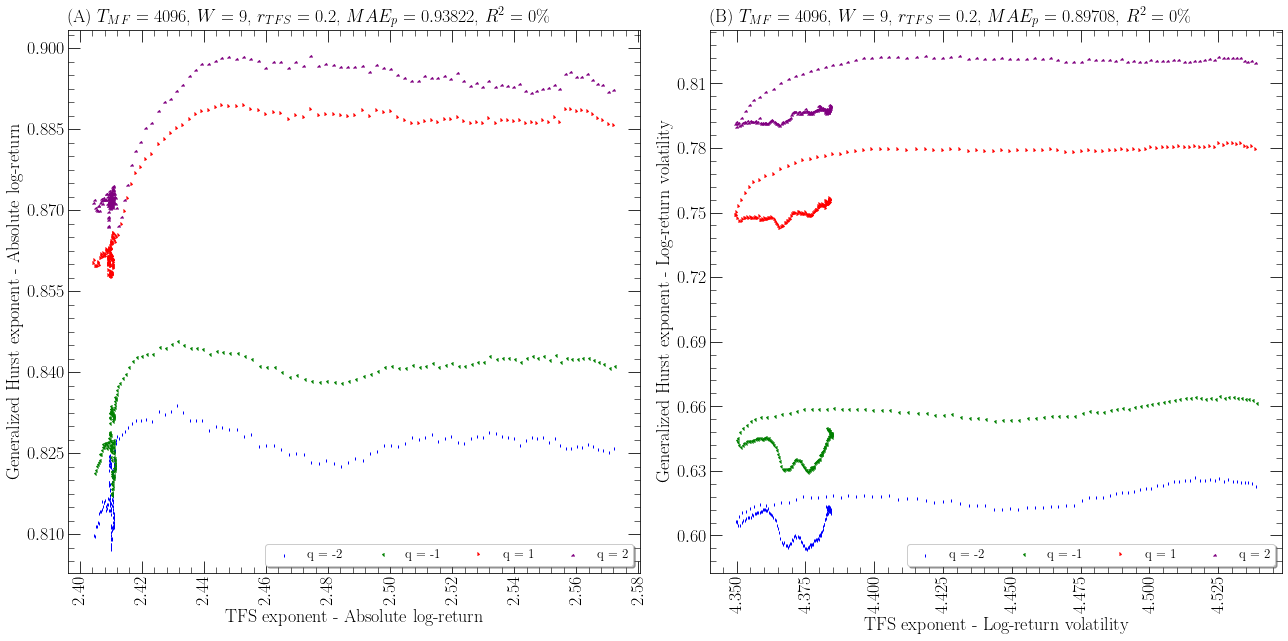

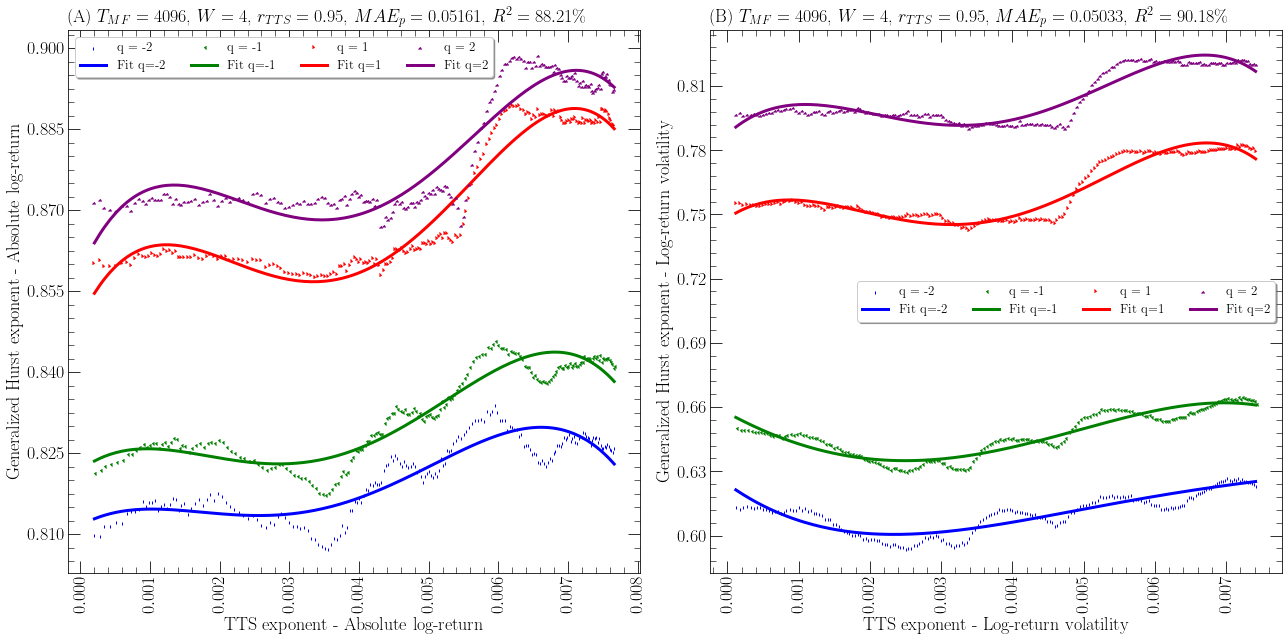

Generated plot for ^IXIC and time series absolute log-return


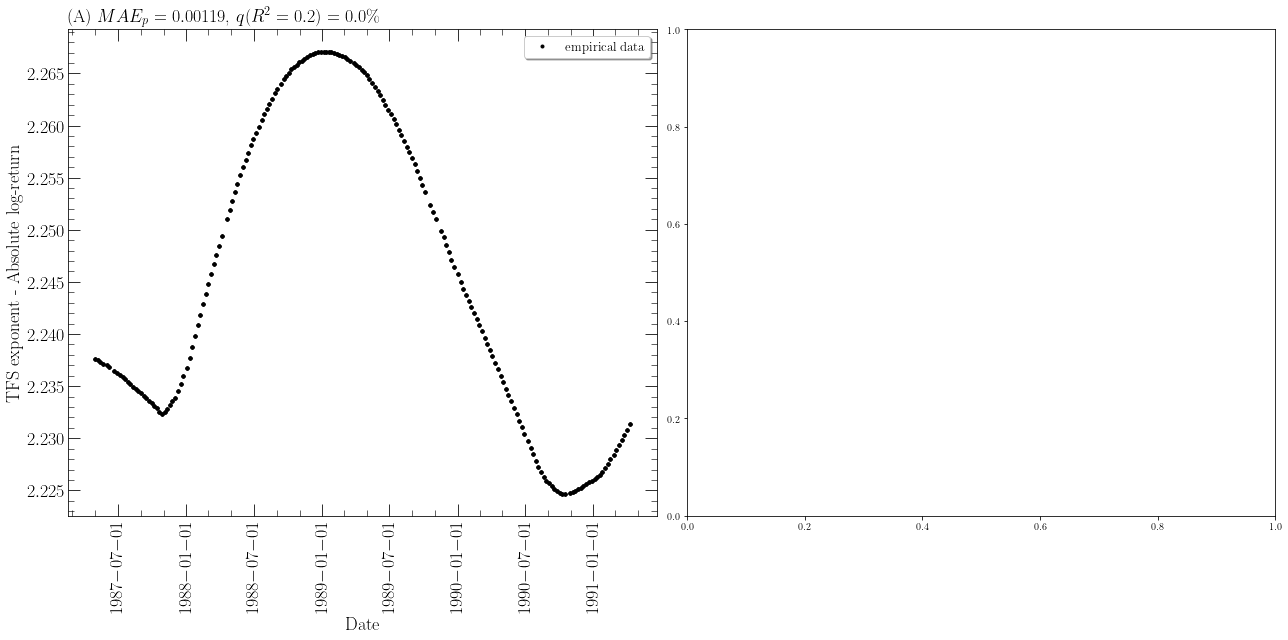

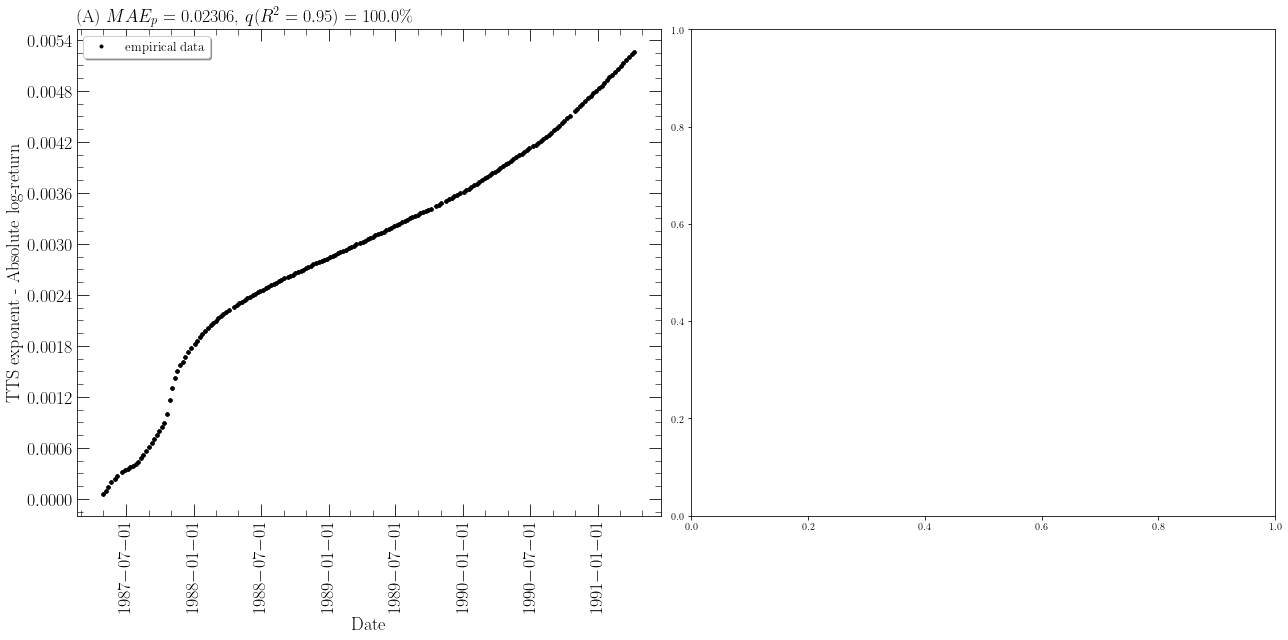

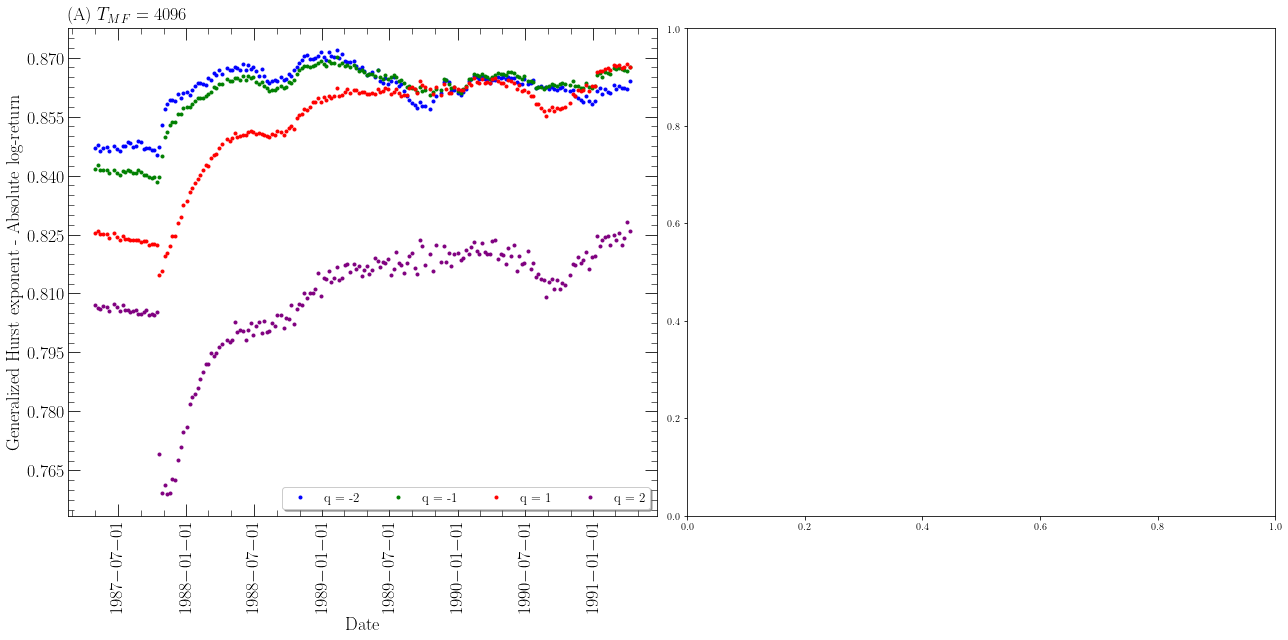

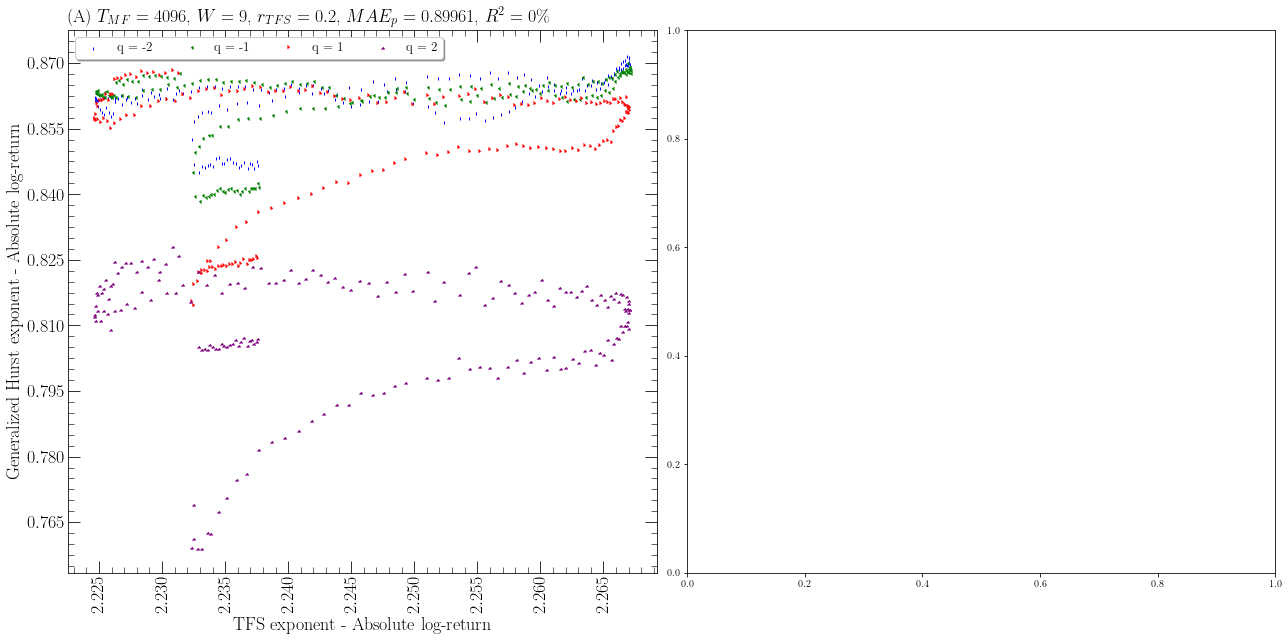

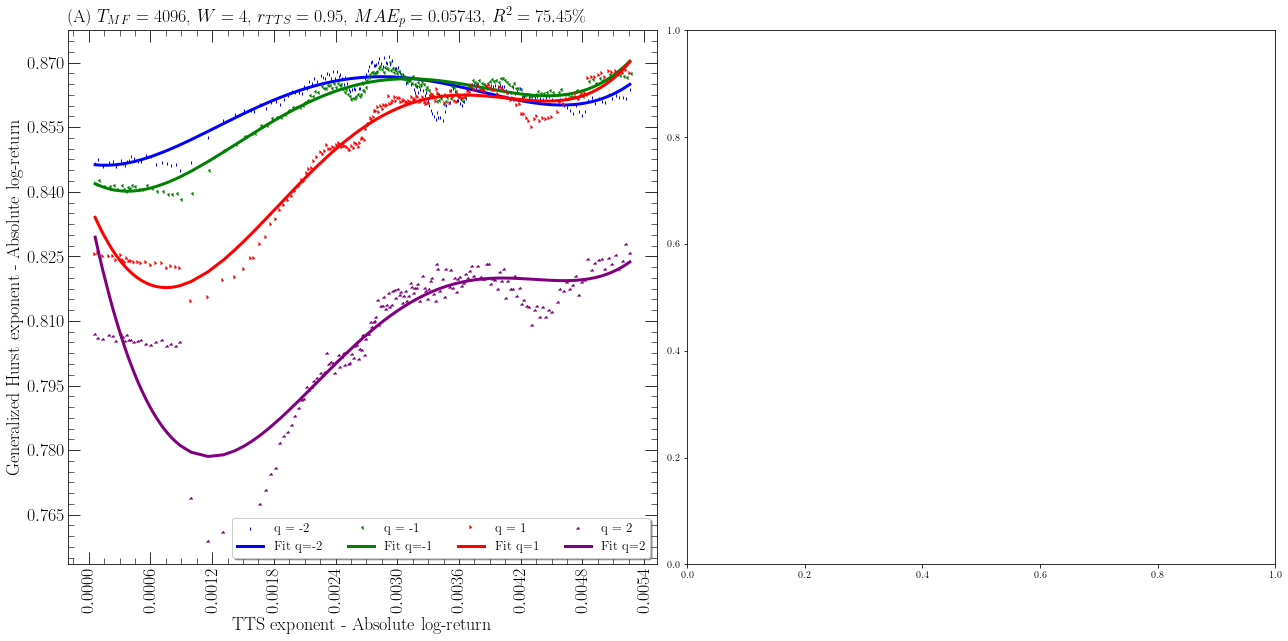

Generated plot for ^MERV and time series absolute log-return
Generated plot for ^MERV and time series log-return volatility


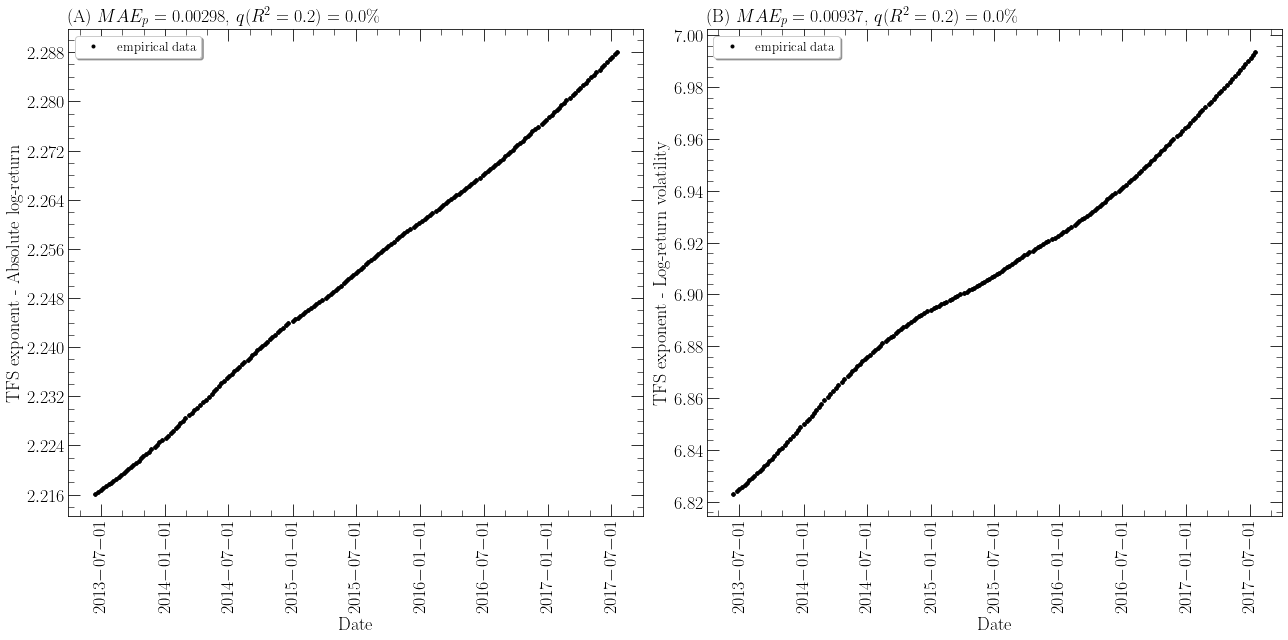

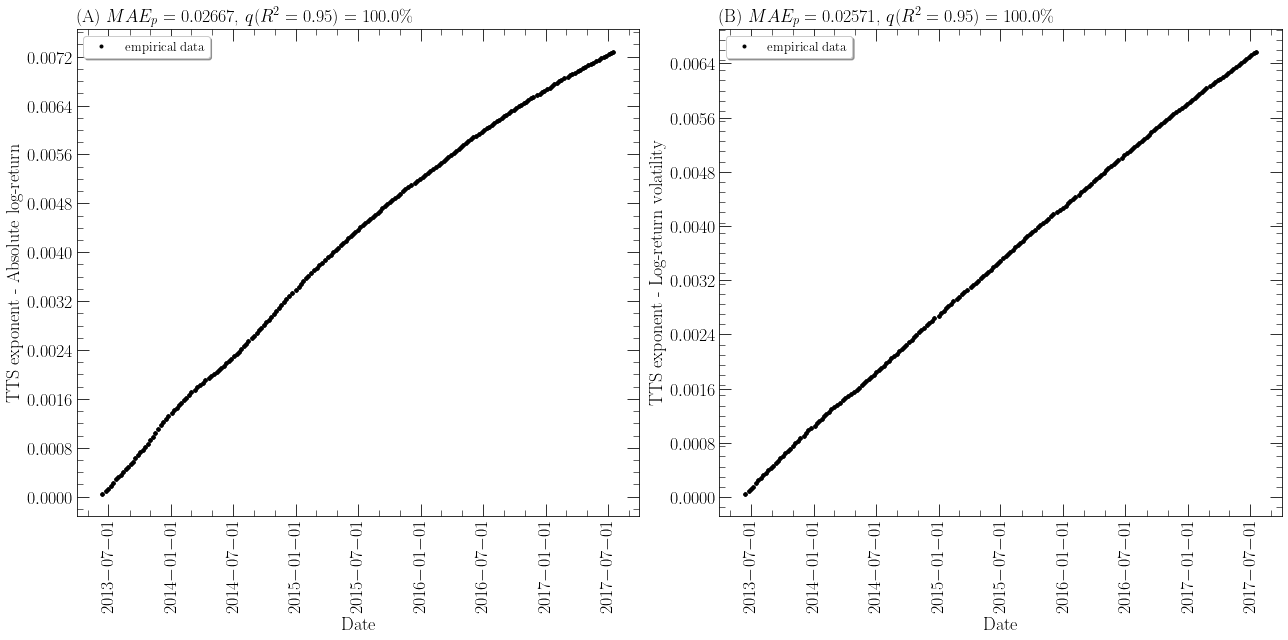

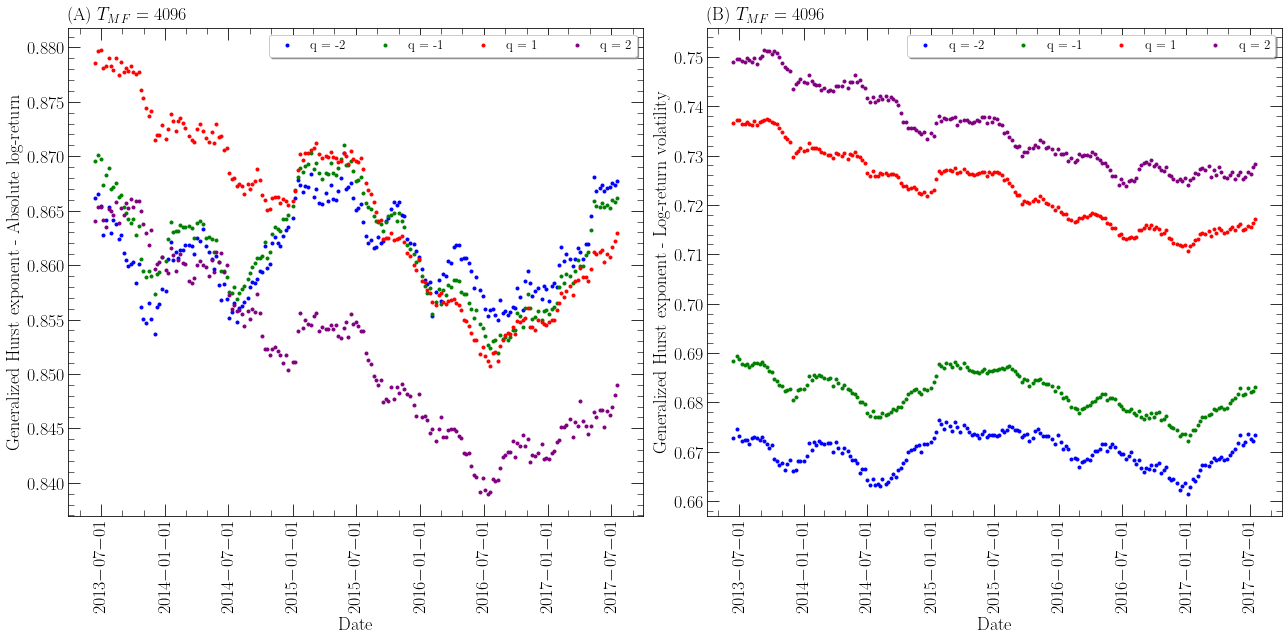

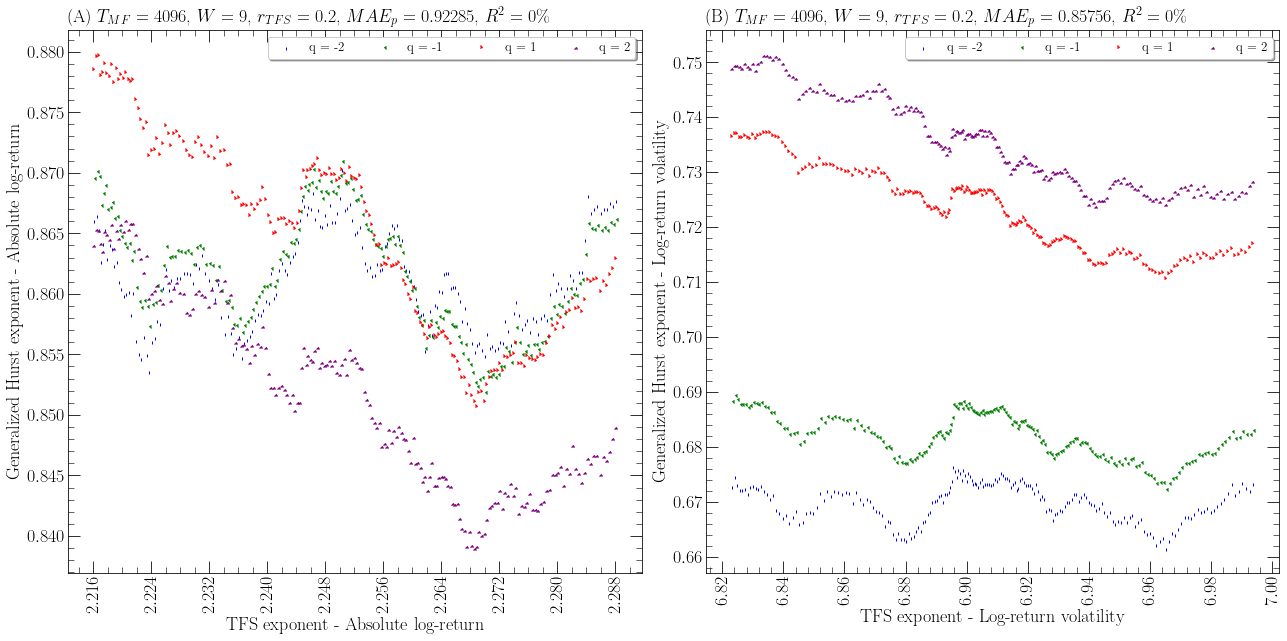

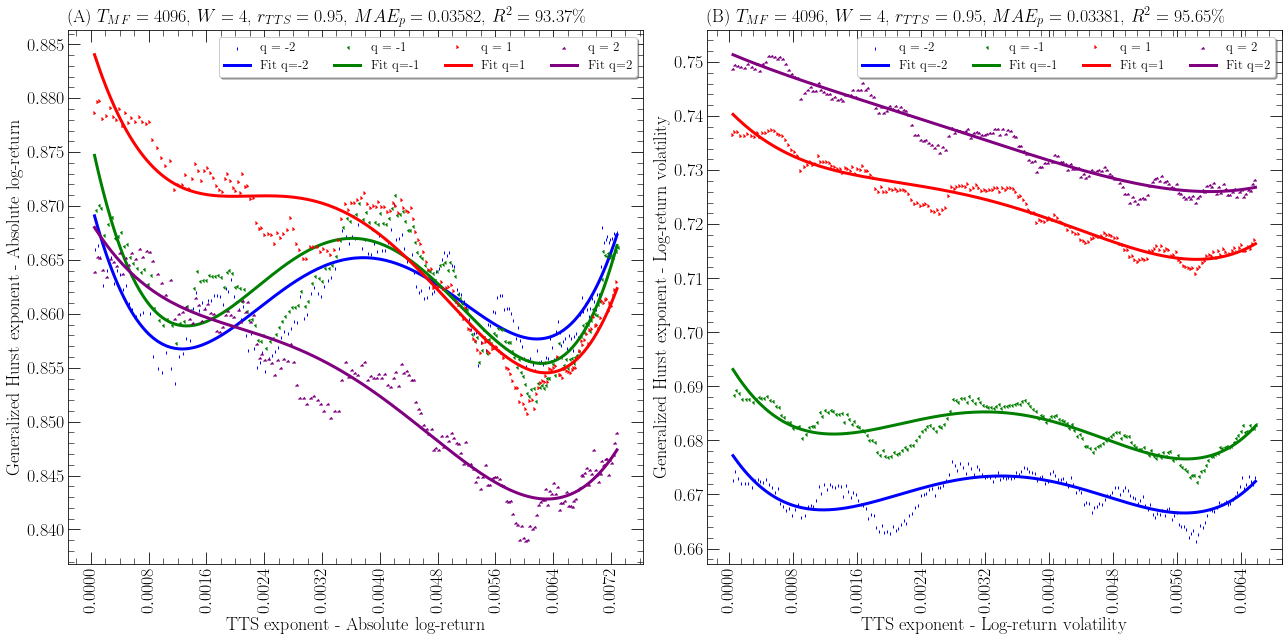

,symbol,time_series,q_order,parameters_tts,error_parameters_tts,rsquared_tts,average_error_tts
0,^DJI,absolute log-return,-2,-1.871111e+08,1.583830e+06,0.918608,0.035587
1,^DJI,absolute log-return,-2,2.462167e+06,1.935511e+04,0.918608,0.035587
2,^DJI,absolute log-return,-2,-9.132773e+03,7.855014e+01,0.918608,0.035587
3,^DJI,absolute log-return,-2,9.546625e+00,1.163299e-01,0.918608,0.035587
4,^DJI,absolute log-return,-2,7.502711e-01,4.454718e-05,0.918608,0.035587
...,...,...,...,...,...,...,...
0,^MERV,log-return volatility,2,2.954092e+07,9.717873e+05,0.956539,0.033808
1,^MERV,log-return volatility,2,-2.920144e+05,1.306012e+04,0.956539,0.033808
2,^MERV,log-return volatility,2,1.023806e+03,5.820951e+01,0.956539,0.033808
3,^MERV,log-return volatility,2,-6.284659e+00,9.672743e-02,0.956539,0.033808


In [28]:
df_hurst_tfs_stock_indexes = pd.DataFrame()
df_hurst_tts_stock_indexes = pd.DataFrame()

for ticker, ticker_name in list_stock_indexes.items():
    df_tfs_aux, df_tts_aux = plt_hurst_tfs.plot_hurst_tfs_tts_evolution(
        df_fts = df_stock_indexes,
        df_hurst = df_stock_indexes_hurst,
        df_tfs = df_stock_indexes_tfs,
        df_tts = df_stock_indexes_tts,
        interval = "days",
        symbols = [ticker],
        q_values = q_values,
        degree_tfs = 9,
        degree_tts = 4,
        width = 18,
        height = 9,
        threshold_n_data_hurst = 4096,
        threshold_tfs = 0.2,
        threshold_tts = 0.95,
        markersize = 3,
        fontsize_labels = 18,
        fontsize_legend = 13,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 10,
        n_y_breaks = 10,
        fancy_legend = True,
        dpi = 200,
        save_figures = True,
        output_path = "{}/{}/stock_index".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = re.sub("(\^)|(=X)", "", ticker),
        input_generation_date = input_generation_date
    )
    
    df_hurst_tfs_stock_indexes = df_hurst_tfs_stock_indexes.append(df_tfs_aux)
    df_hurst_tts_stock_indexes = df_hurst_tts_stock_indexes.append(df_tts_aux)

#df_hurst_tfs_stock_indexes
df_hurst_tts_stock_indexes

Generated plot for MXN=X and time series absolute log-return
Generated plot for MXN=X and time series log-return volatility


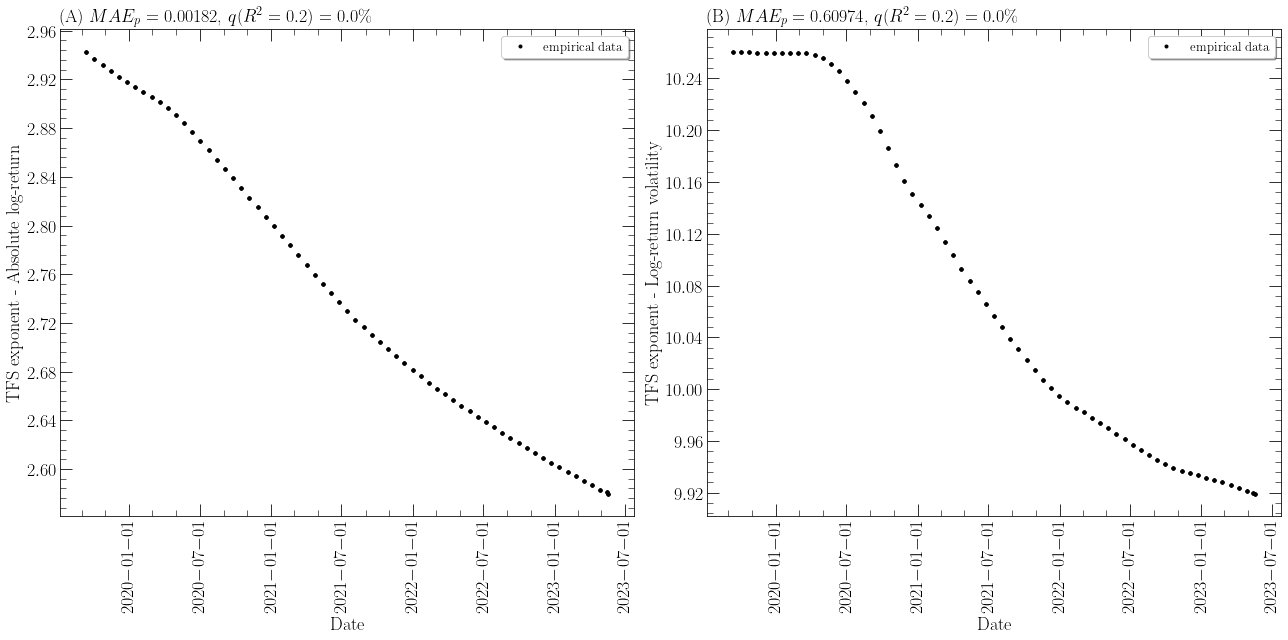

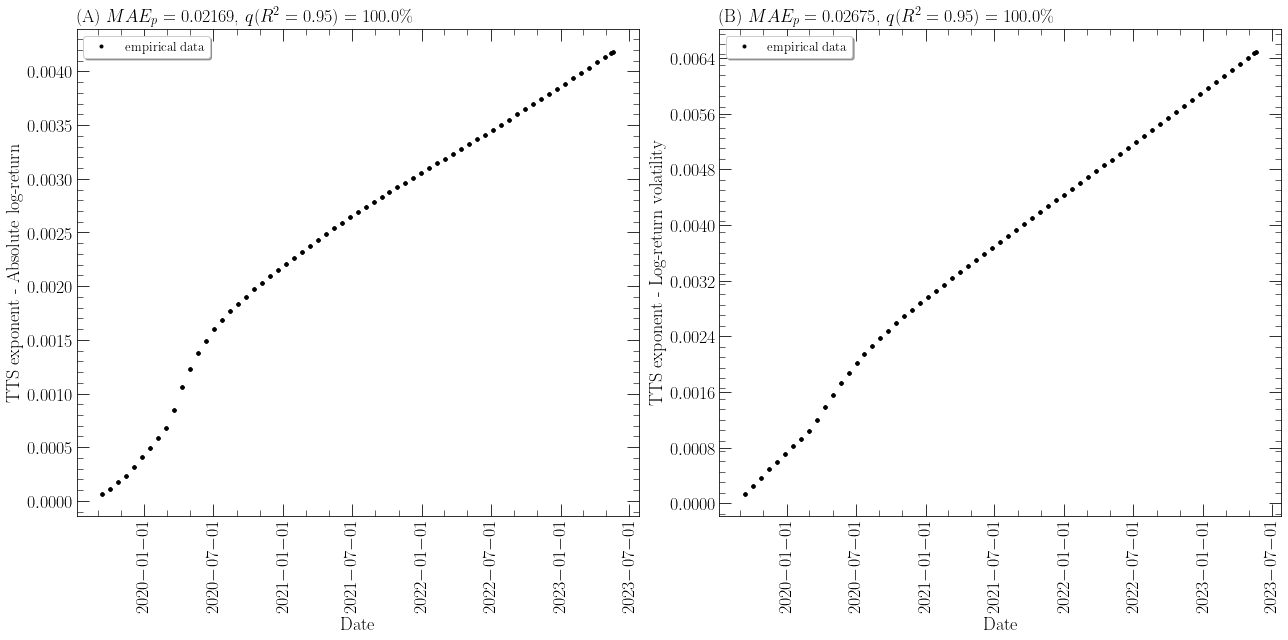

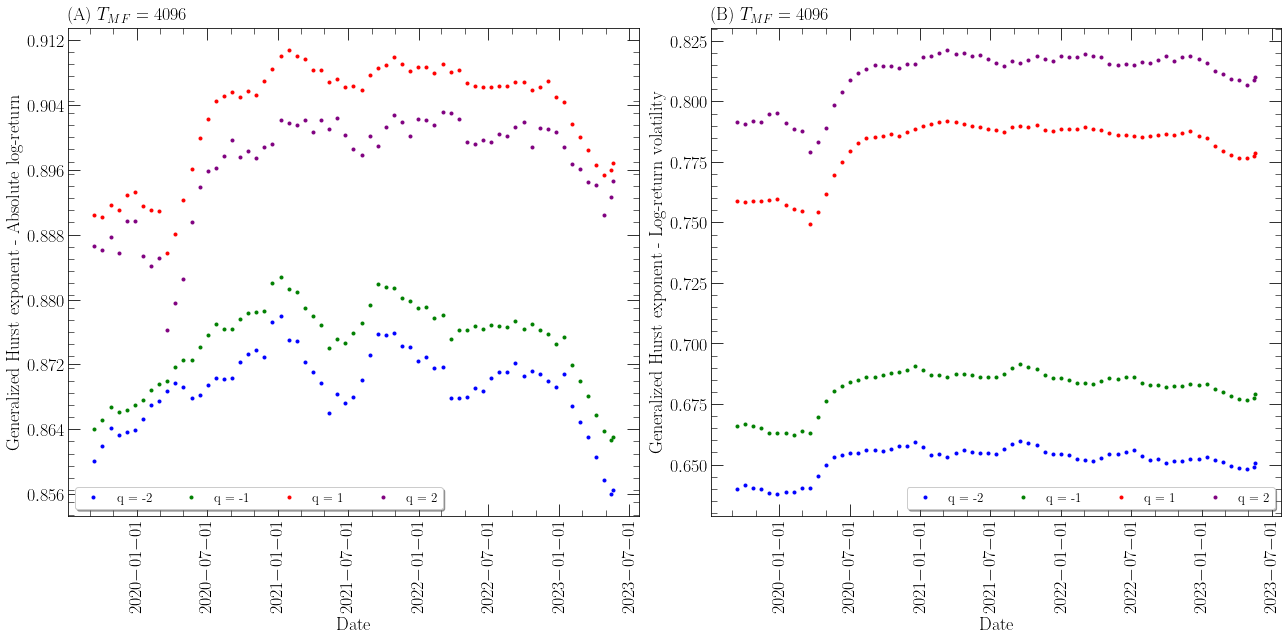

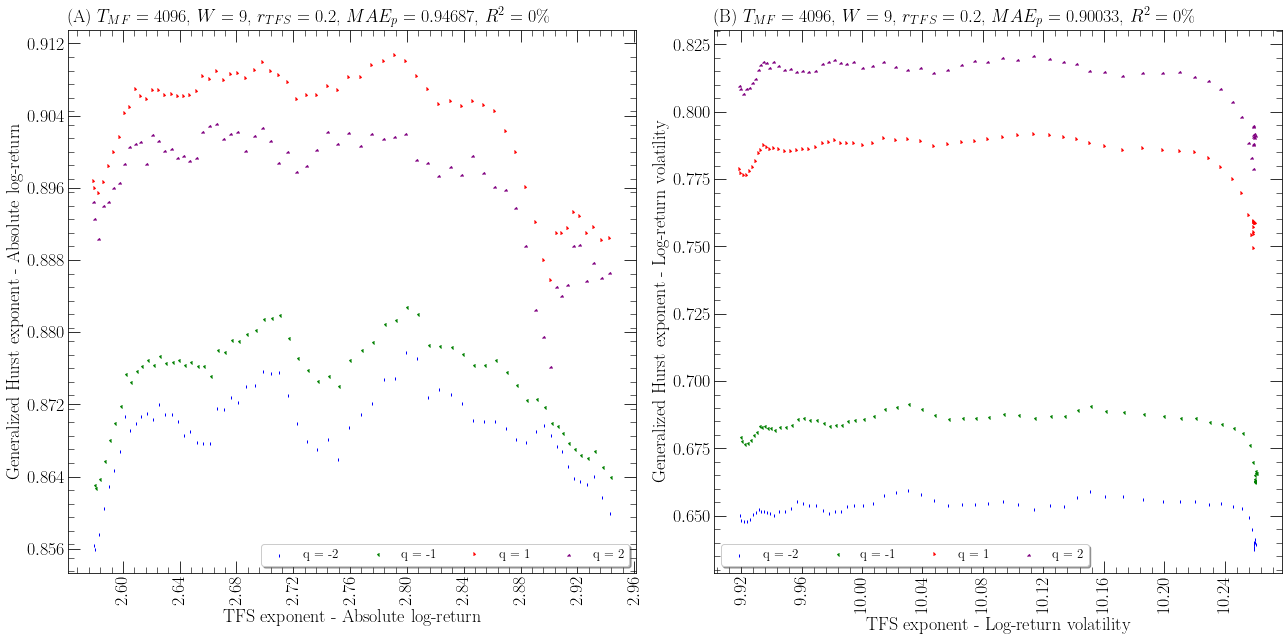

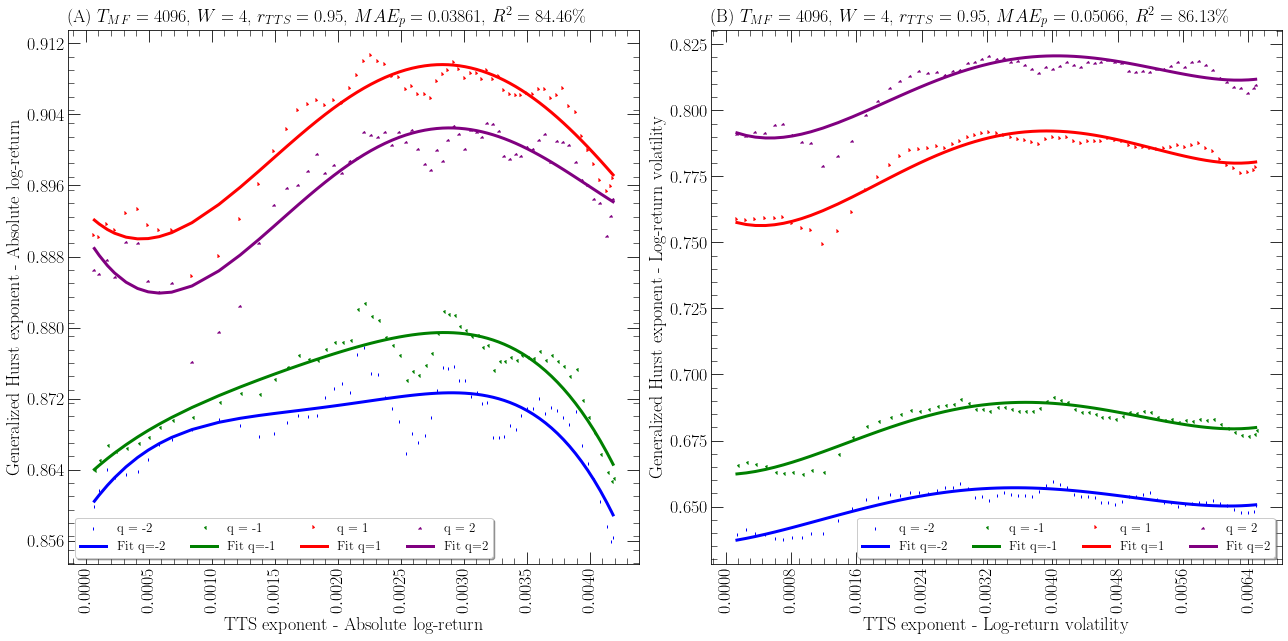

Generated plot for EURCOP=X and time series absolute log-return
Generated plot for EURCOP=X and time series log-return volatility


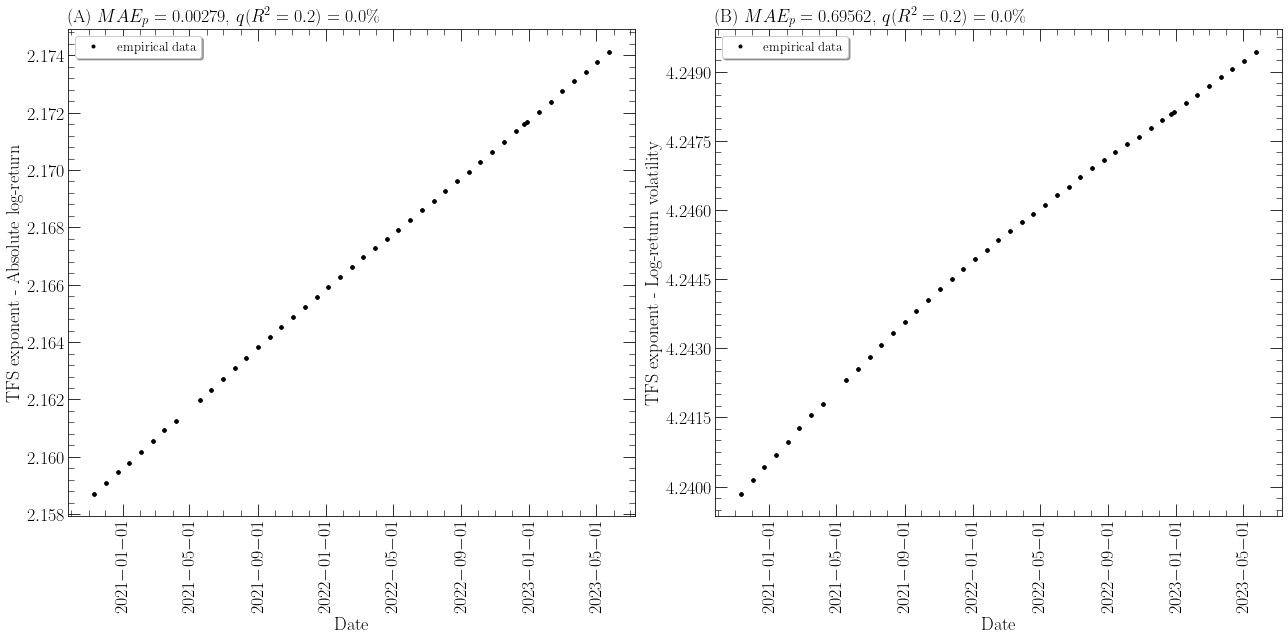

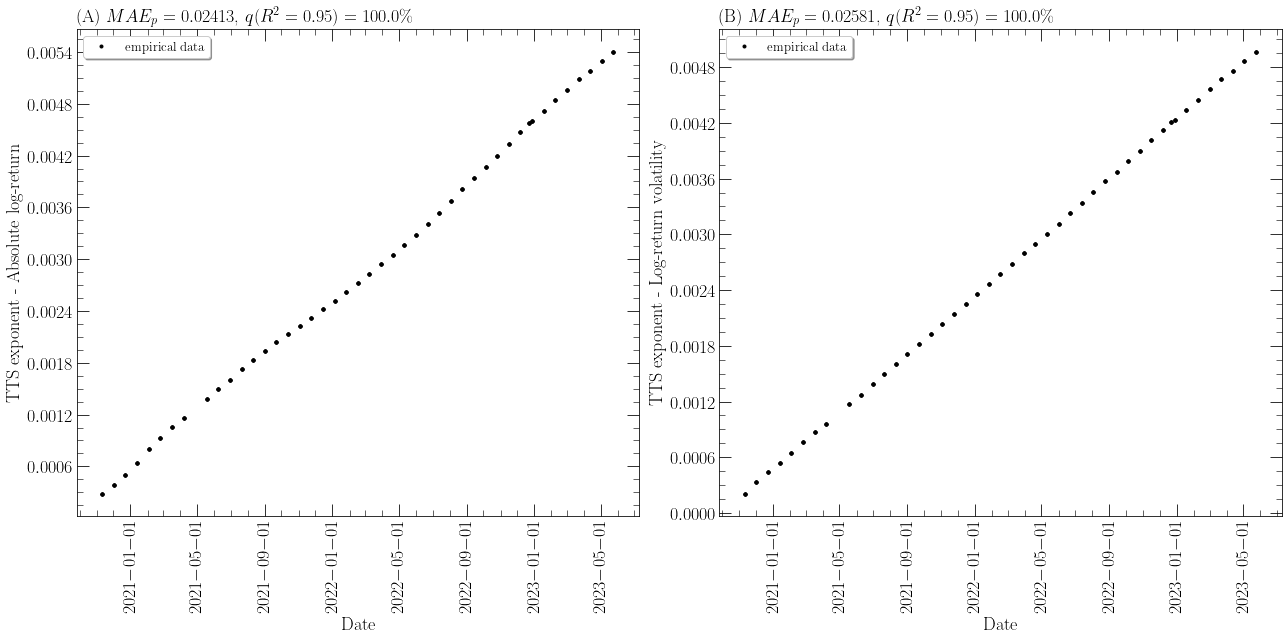

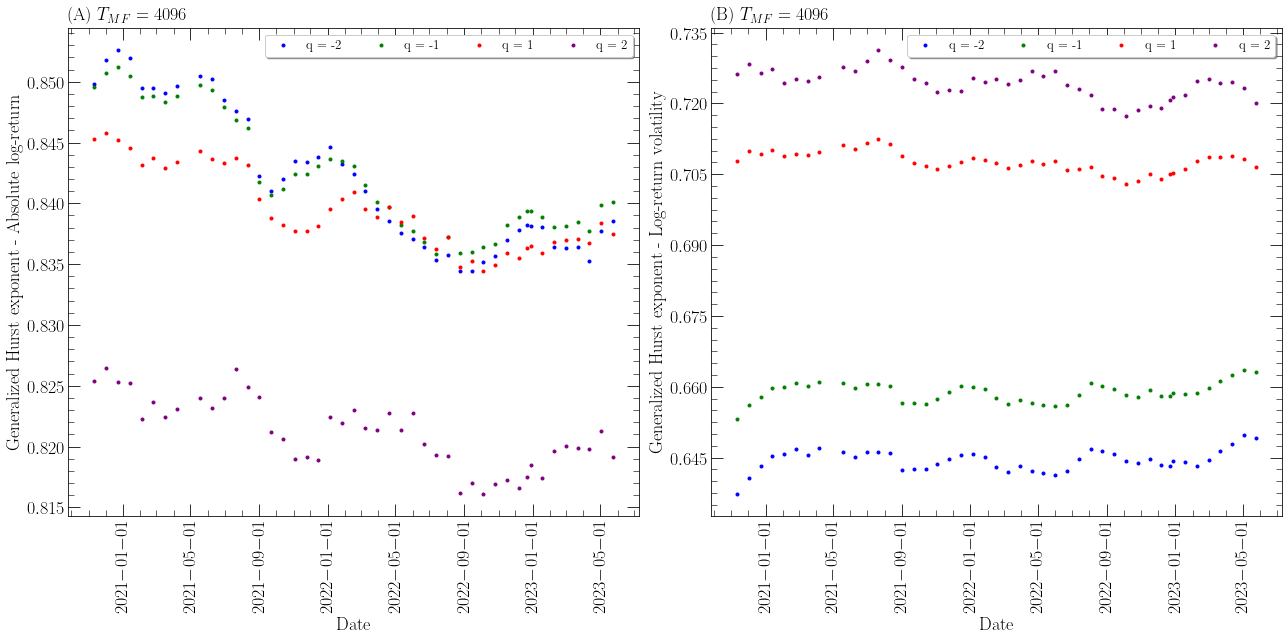

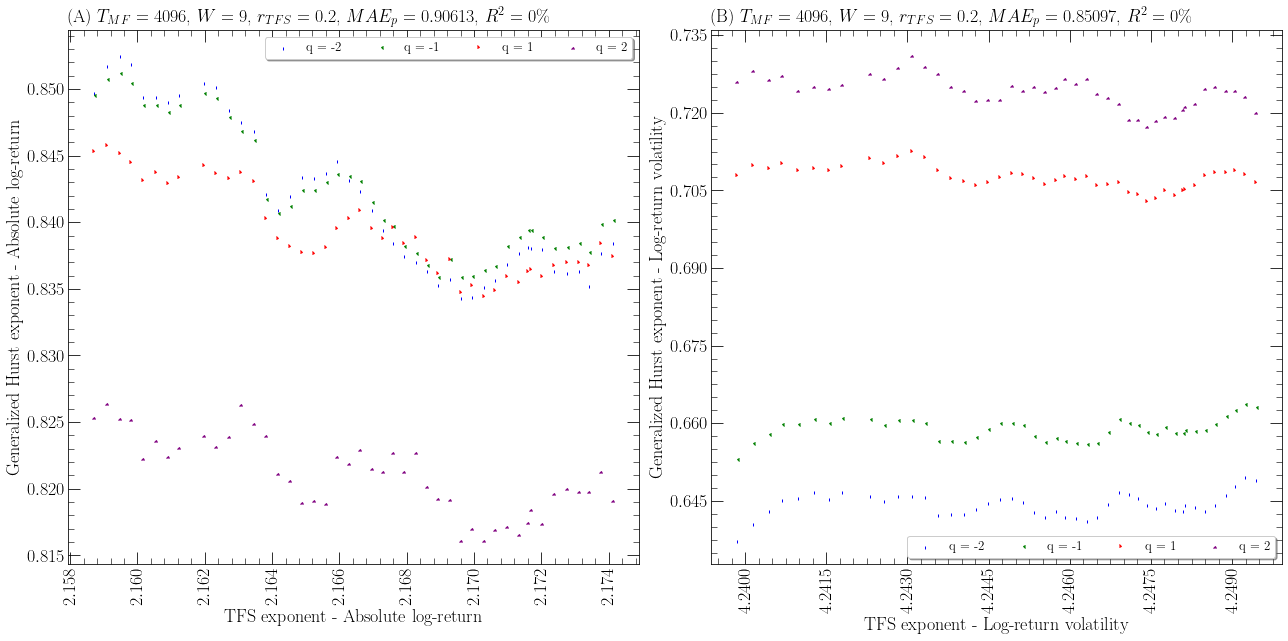

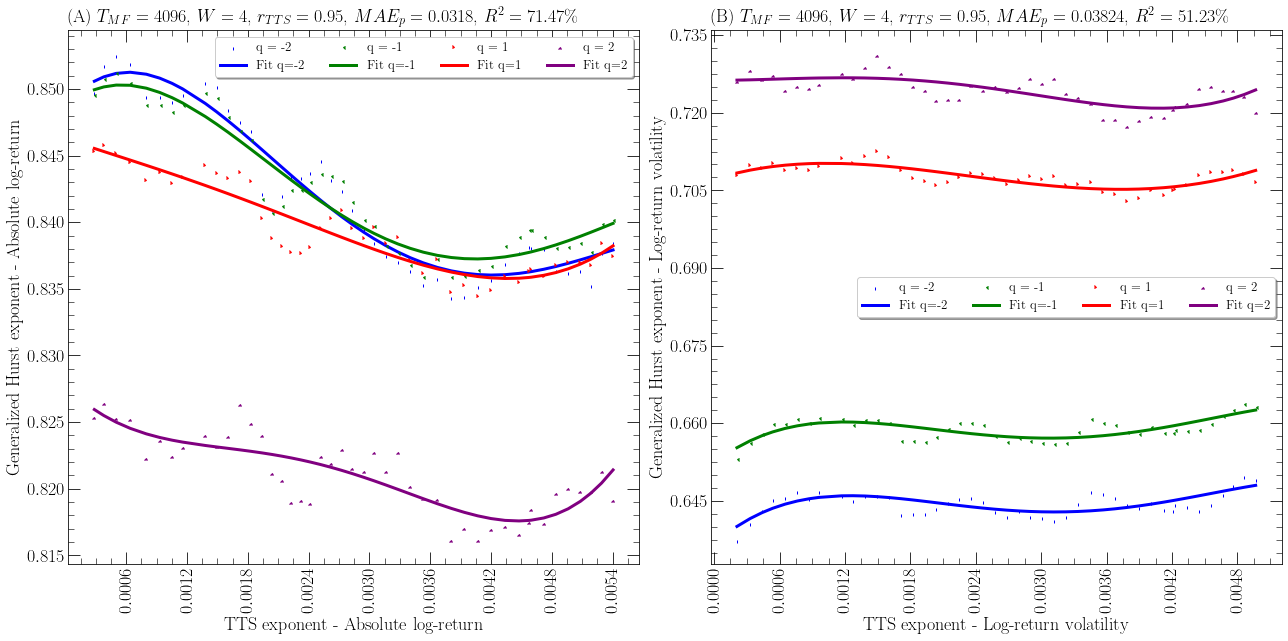

,symbol,time_series,q_order,parameters_tts,error_parameters_tts,rsquared_tts,average_error_tts
0,MXN=X,absolute log-return,-2,-7.071969e+08,2.778813e+07,0.702713,0.040783
1,MXN=X,absolute log-return,-2,5.452401e+06,2.457745e+05,0.702713,0.040783
2,MXN=X,absolute log-return,-2,-1.538217e+04,7.231662e+02,0.702713,0.040783
3,MXN=X,absolute log-return,-2,2.067085e+01,7.816259e-01,0.702713,0.040783
4,MXN=X,absolute log-return,-2,8.591233e-01,2.236582e-04,0.702713,0.040783
...,...,...,...,...,...,...,...
0,EURCOP=X,log-return volatility,2,1.393876e+08,1.918154e+07,0.512298,0.038236
1,EURCOP=X,log-return volatility,2,-9.858274e+05,2.012223e+05,0.512298,0.038236
2,EURCOP=X,log-return volatility,2,1.402399e+03,7.085206e+02,0.512298,0.038236
3,EURCOP=X,log-return volatility,2,-1.009095e-01,9.464981e-01,0.512298,0.038236


In [29]:
df_hurst_tfs_currencies = pd.DataFrame()
df_hurst_tts_currencies = pd.DataFrame()

for ticker, ticker_name in list_currencies.items():
    df_tfs_aux, df_tts_aux = plt_hurst_tfs.plot_hurst_tfs_tts_evolution(
        df_fts = df_currencies,
        df_hurst = df_currencies_hurst,
        df_tfs = df_currencies_tfs,
        df_tts = df_currencies_tts,
        interval = "days",
        symbols = [ticker],
        q_values = q_values,
        degree_tfs = 9,
        degree_tts = 4,
        width = 18,
        height = 9,
        threshold_n_data_hurst = 4096,
        threshold_tfs = 0.2,
        threshold_tts = 0.95,
        markersize = 3,
        fontsize_labels = 18,
        fontsize_legend = 13,
        usetex = True,
        n_cols = 4,
        n_x_breaks = 10,
        n_y_breaks = 10,
        fancy_legend = True,
        dpi = 200,
        save_figures = True,
        output_path = "{}/{}/currency".format(output_path, re.sub("-", "", input_generation_date)),
        information_name = re.sub("(\^)|(=X)", "", ticker),
        input_generation_date = input_generation_date
    )
    
    df_hurst_tfs_currencies = df_hurst_tfs_currencies.append(df_tfs_aux)
    df_hurst_tts_currencies = df_hurst_tts_currencies.append(df_tts_aux)

#df_hurst_tfs_currencies
df_hurst_tts_currencies

## Save Hurst - TFS data

In [14]:
df_hurst_tfs_stock_indexes.to_csv("{}/df_hurst_tfs_stock_index_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)
df_hurst_tts_stock_indexes.to_csv("{}/df_hurst_tts_stock_index_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)

In [15]:
df_hurst_tfs_currencies.to_csv("{}/df_hurst_tfs_currency_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)
df_hurst_tts_currencies.to_csv("{}/df_hurst_tts_currency_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)

In [14]:
df_hurst_tts_stock_indexes[df_hurst_tts_stock_indexes["rsquared_tts"] >= 0.8]

,symbol,time_series,q_order,parameters_tts,error_parameters_tts,rsquared_tts,average_error_tts
0,^DJI,absolute log-return,-2,-1.871111e+08,1.583830e+06,0.918608,0.035587
1,^DJI,absolute log-return,-2,2.462167e+06,1.935511e+04,0.918608,0.035587
2,^DJI,absolute log-return,-2,-9.132773e+03,7.855014e+01,0.918608,0.035587
3,^DJI,absolute log-return,-2,9.546625e+00,1.163299e-01,0.918608,0.035587
4,^DJI,absolute log-return,-2,7.502711e-01,4.454718e-05,0.918608,0.035587
...,...,...,...,...,...,...,...
0,^MERV,log-return volatility,2,2.954092e+07,9.717873e+05,0.956539,0.033808
1,^MERV,log-return volatility,2,-2.920144e+05,1.306012e+04,0.956539,0.033808
2,^MERV,log-return volatility,2,1.023806e+03,5.820951e+01,0.956539,0.033808
3,^MERV,log-return volatility,2,-6.284659e+00,9.672743e-02,0.956539,0.033808


In [15]:
df_hurst_tts_currencies[df_hurst_tts_currencies["rsquared_tts"] >= 0.8]

,symbol,time_series,q_order,parameters_tts,error_parameters_tts,rsquared_tts,average_error_tts
0,MXN=X,absolute log-return,-1,-4.116890e+08,2.140609e+07,0.858907,0.034895
1,MXN=X,absolute log-return,-1,2.578967e+06,1.893279e+05,0.858907,0.034895
2,MXN=X,absolute log-return,-1,-6.696519e+03,5.570781e+02,0.858907,0.034895
3,MXN=X,absolute log-return,-1,1.338660e+01,6.021114e-01,0.858907,0.034895
4,MXN=X,absolute log-return,-1,8.631462e-01,1.722910e-04,0.858907,0.034895
0,MXN=X,absolute log-return,1,5.305758e+08,2.265898e+07,0.905638,0.037320
1,MXN=X,absolute log-return,1,-6.343033e+06,2.004093e+05,0.905638,0.037320
2,MXN=X,absolute log-return,1,2.108445e+04,5.896838e+02,0.905638,0.037320
3,MXN=X,absolute log-return,1,-1.504009e+01,6.373529e-01,0.905638,0.037320
4,MXN=X,absolute log-return,1,8.930335e-01,1.823752e-04,0.905638,0.037320


## Construction of coefficient matrix

In [16]:
df_matrix_resume = pd.DataFrame()
df_local = df_hurst_tts_stock_indexes
for i in sorted(df_local["symbol"].unique()):
    for j in sorted(df_local["time_series"].unique()):
        local_matrix = []
        for k in sorted(df_local["q_order"].unique()):
            print("Symbol: {}, Time series: {} and q={}".format(i, j, k))
            df_aux = df_local[((df_local["symbol"] == i) & (df_local["time_series"] == j) & (df_local["q_order"] == k))]
            local_matrix.append(df_aux["parameters_tts"].tolist())
        
        local_matrix = np.array(local_matrix)
        local_matrix = np.matmul(local_matrix, local_matrix.transpose())
        
        eigenvalues, eigenvectors = np.linalg.eig(local_matrix)
        
        singular_value = np.sqrt(np.max(eigenvalues))
        eigenvector = eigenvectors[np.argmax(eigenvalues)]
        
        df_matrix_resume = df_matrix_resume.append(
            pd.DataFrame(
                {
                    "symbol" : [i] * eigenvector.shape[0],
                    "time_series" : [j] * eigenvector.shape[0],
                    "q_order" : sorted(df_hurst_tts_stock_indexes["q_order"].unique()),
                    "matrix_norm" : [singular_value] * eigenvector.shape[0],
                    "eigenvector" : eigenvector
                }
            )
        )

df_matrix_resume.to_csv("{}/df_hurst_tts_optimal_stock_index_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)

Symbol: ^DJI, Time series: absolute log-return and q=-2
Symbol: ^DJI, Time series: absolute log-return and q=-1
Symbol: ^DJI, Time series: absolute log-return and q=1
Symbol: ^DJI, Time series: absolute log-return and q=2
Symbol: ^DJI, Time series: log-return volatility and q=-2
Symbol: ^DJI, Time series: log-return volatility and q=-1
Symbol: ^DJI, Time series: log-return volatility and q=1
Symbol: ^DJI, Time series: log-return volatility and q=2
Symbol: ^FCHI, Time series: absolute log-return and q=-2
Symbol: ^FCHI, Time series: absolute log-return and q=-1
Symbol: ^FCHI, Time series: absolute log-return and q=1
Symbol: ^FCHI, Time series: absolute log-return and q=2
Symbol: ^FCHI, Time series: log-return volatility and q=-2
Symbol: ^FCHI, Time series: log-return volatility and q=-1
Symbol: ^FCHI, Time series: log-return volatility and q=1
Symbol: ^FCHI, Time series: log-return volatility and q=2
Symbol: ^IXIC, Time series: absolute log-return and q=-2
Symbol: ^IXIC, Time series: abs

In [17]:
df_matrix_resume = pd.DataFrame()
df_local = df_hurst_tts_currencies
for i in sorted(df_local["symbol"].unique()):
    for j in sorted(df_local["time_series"].unique()):
        local_matrix = []
        for k in sorted(df_local["q_order"].unique()):
            print("Symbol: {}, Time series: {} and q={}".format(i, j, k))
            df_aux = df_local[((df_local["symbol"] == i) & (df_local["time_series"] == j) & (df_local["q_order"] == k))]
            local_matrix.append(df_aux["parameters_tts"].tolist())
        
        local_matrix = np.array(local_matrix)
        local_matrix = np.matmul(local_matrix, local_matrix.transpose())
        
        eigenvalues, eigenvectors = np.linalg.eig(local_matrix)
        
        singular_value = np.sqrt(np.max(eigenvalues))
        eigenvector = eigenvectors[np.argmax(eigenvalues)]
        
        df_matrix_resume = df_matrix_resume.append(
            pd.DataFrame(
                {
                    "symbol" : [i] * eigenvector.shape[0],
                    "time_series" : [j] * eigenvector.shape[0],
                    "q_order" : sorted(df_hurst_tts_stock_indexes["q_order"].unique()),
                    "matrix_norm" : [singular_value] * eigenvector.shape[0],
                    "eigenvector" : eigenvector
                }
            )
        )

df_matrix_resume.to_csv("{}/df_hurst_tts_optimal_currency_{}.csv".format(output_path, re.sub("-", "", input_generation_date)) , index = False)

Symbol: EURCOP=X, Time series: absolute log-return and q=-2
Symbol: EURCOP=X, Time series: absolute log-return and q=-1
Symbol: EURCOP=X, Time series: absolute log-return and q=1
Symbol: EURCOP=X, Time series: absolute log-return and q=2
Symbol: EURCOP=X, Time series: log-return volatility and q=-2
Symbol: EURCOP=X, Time series: log-return volatility and q=-1
Symbol: EURCOP=X, Time series: log-return volatility and q=1
Symbol: EURCOP=X, Time series: log-return volatility and q=2
Symbol: MXN=X, Time series: absolute log-return and q=-2
Symbol: MXN=X, Time series: absolute log-return and q=-1
Symbol: MXN=X, Time series: absolute log-return and q=1
Symbol: MXN=X, Time series: absolute log-return and q=2
Symbol: MXN=X, Time series: log-return volatility and q=-2
Symbol: MXN=X, Time series: log-return volatility and q=-1
Symbol: MXN=X, Time series: log-return volatility and q=1
Symbol: MXN=X, Time series: log-return volatility and q=2
